In [1]:
import os, time, math, csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
pd.options.display.float_format = '{:.2f}'.format

C:\Users\Shaoxuan\anaconda3\lib\site-packages\scipy\__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping

def ann():
    model = Sequential()
    for i in range(len(hidden_layers)):
        if i==0:
            model.add(Dense(hidden_layers[i][0], input_dim = ncol-1, activation = hidden_layers[i][1]))
        else:
            model.add(Dense(hidden_layers[i][0],activation=hidden_layers[i][1]))
    model.add(Dense(1))
    model.compile(loss =loss_function ,optimizer = optimizer)
    return model

In [3]:
#STATIC PARAMETERS (DO NOT TOUCH)
data_path=os.getcwd()+"\\data"
trainingProp=0.80

batch_size=32 #Batch size
hidden_layers=[(24,"tanh"),(12,"tanh")] # Number and type of hidden layers
loss_function='mean_squared_error' #loss function for training
optimizer='RMSprop' #training optimizer
early_stopping="loss" #early stopping criteria
patience=50 #Number of epochs without improving loss
n_epochs=5000 #Number of epochs (at least 5000)
y_name="total_UL_traffic metro" #Response variable (what we want to predict)

#TUNABLE PARAMETERS
#awDataFile="metro_flexible_25_25_3" #ANT!!!!!!!!! Do not put ".csv" extension when writting the name
rawDataFile="Scenario_s100_l80_flexible_summary"
w=20 # Number of previous measurements of the response variable
#x_names=["general_active antennas","total_slicing_0_capacity","total_slicing_1_capacity", "total_slicing_2_capacity","total_UL_traffic metro","total_slicing_0_CU","total_slicing_1_CU","total_slicing_2_CU","total_slicing_0_DU","total_slicing_1_DU","total_slicing_2_DU"] # RAN variables that we want to include in the model
x_names=[] #This is the configuration for model 1 (no RAN variables)

In [4]:
DF_raw=pd.read_csv(data_path+'\\'+rawDataFile+".csv", sep=";")
nrow,ncol = DF_raw.shape
#print(DF_raw)

In [5]:
header=["y"]+["y_"+str(i+1) for i in range(w)]+x_names
data_proc=[]
for i in range(w,nrow):
    this_row=[]
    this_row.append(DF_raw[y_name][i])
    aux=list(DF_raw[y_name][(i-w):i])
    aux.reverse()
    this_row+=aux
    if len(x_names)>0:
        this_row+=list(DF_raw.iloc[i,:][x_names])
    data_proc.append(this_row)
DF_proc=pd.DataFrame(data_proc)
DF_proc.columns=header

In [6]:
nrow,ncol = DF_proc.shape
R=np.random.permutation(nrow)
trainingProp=0.8

#R=list(range(nrow))
nt=math.ceil(nrow*trainingProp)
rows_training=R[0:nt]
rows_testing=R[(nt):(nrow+1)]

DF_training=DF_proc.iloc[rows_training,:]
DF_testing=DF_proc.iloc[rows_testing,:]

Y=DF_training.iloc[:,0].to_numpy().reshape(-1,1)
X=DF_training.iloc[:,1:ncol]
sc_input = MinMaxScaler()
sc_output = MinMaxScaler()
X_train = sc_input.fit_transform(X)
Y_train = sc_output.fit_transform(Y)

Y=DF_testing.iloc[:,0].to_numpy().reshape(-1,1)
X=DF_testing.iloc[:,1:ncol]
X_test = sc_input.transform(X)
Y_test = sc_output.transform(Y)

data_increments=[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
error_results_avg=[]
error_results_max=[]

#Total number of training rows
nrows_training=float(DF_training.shape[0])
print("total nrows training: ", nrows_training)
for prop in data_increments:
    #TODO: X and Y should have prop*
    last_row=int(np.ceil(nrows_training*prop)-1)
    print("last row: ", last_row)
    
    Y=DF_training.iloc[0:last_row,0].to_numpy().reshape(-1,1)
    X=DF_training.iloc[0:last_row,1:ncol]
    
    X_train = sc_input.transform(X)
    Y_train = sc_output.transform(Y)


    model_ann = KerasRegressor(build_fn=ann,epochs=n_epochs,batch_size=batch_size)

    start_time = time.time()
    callback = EarlyStopping(monitor=early_stopping, patience=patience)
    model_ann.fit(X_train, Y_train, callbacks=[callback])
    time_train_ann = time.time() - start_time

    start_time = time.time()
    Y_test_pred=model_ann.predict(X_test)
    time_eval_ann=time.time()-start_time

    real=list(list(zip(*Y_test))[0])
    pred=list(Y_test_pred)

    dist_min=sc_output.data_min_[0]
    dist_max=sc_output.data_max_[0]

    real_abs=np.add(dist_min,np.multiply((dist_max-dist_min),real))
    pred_abs=np.add(dist_min,np.multiply((dist_max-dist_min),pred))

    error=np.divide(np.abs(np.subtract(np.array(real_abs),np.array(pred_abs))),np.array(real_abs))
    error_results_avg.append(np.mean(error))
    error_results_max.append(np.max(error))


total nrows training:  10352.0
last row:  103
Epoch 1/5000


C:\Users\Shaoxuan\AppData\Local\Temp\ipykernel_17320\263528559.py:44: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_ann = KerasRegressor(build_fn=ann,epochs=n_epochs,batch_size=batch_size)


4/4 [==============================] - 0s 2ms/step - loss: 0.0651
Epoch 2/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0255
Epoch 3/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0208
Epoch 4/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.0184
Epoch 5/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0225
Epoch 6/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0187
Epoch 7/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.0178
Epoch 8/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0198
Epoch 9/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0226
Epoch 10/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0122
Epoch 11/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.0168
Epoch 12/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0135
Epoch 13/5000
4/4 [==============================] - 0s 998us/

4/4 [==============================] - 0s 1ms/step - loss: 0.0065
Epoch 104/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0066
Epoch 105/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0034
Epoch 106/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0101
Epoch 107/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0064
Epoch 108/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0057
Epoch 109/5000
4/4 [==============================] - 0s 997us/step - loss: 0.0051
Epoch 110/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 111/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0059
Epoch 112/5000
4/4 [==============================] - 0s 996us/step - loss: 0.0057
Epoch 113/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0134
Epoch 114/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0036
Epoch 115/5000
4/4 [===================

4/4 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 205/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 206/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0075
Epoch 207/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.0056
Epoch 208/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0048
Epoch 209/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0046
Epoch 210/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0033
Epoch 211/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0039
Epoch 212/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0054
Epoch 213/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 214/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0028
Epoch 215/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 216/5000
4/4 [=======================

4/4 [==============================] - 0s 1ms/step - loss: 0.0038
Epoch 305/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0043
Epoch 306/5000
4/4 [==============================] - 0s 997us/step - loss: 0.0054
Epoch 307/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0037
Epoch 308/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0054
Epoch 309/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0028
Epoch 310/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 311/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 312/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0091
Epoch 313/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0036
Epoch 314/5000
4/4 [==============================] - 0s 996us/step - loss: 0.0036
Epoch 315/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch 316/5000
4/4 [===================

4/4 [==============================] - 0s 998us/step - loss: 0.0024
Epoch 405/5000
4/4 [==============================] - 0s 997us/step - loss: 0.0047
Epoch 406/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0043
Epoch 407/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0031
Epoch 408/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0062
Epoch 409/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 410/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0028
Epoch 411/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0021
Epoch 412/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0028
Epoch 413/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 414/5000
4/4 [==============================] - 0s 997us/step - loss: 0.0085
Epoch 415/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 416/5000
4/4 [=================

4/4 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 505/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0051
Epoch 506/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 507/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0030
Epoch 508/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 509/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0021
Epoch 510/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 511/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 512/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 513/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 514/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 515/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0031
Epoch 516/5000
4/4 [=======================

4/4 [==============================] - 0s 1ms/step - loss: 0.0045
Epoch 605/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 606/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 607/5000
4/4 [==============================] - 0s 998us/step - loss: 0.0026
Epoch 608/5000
81/81 [==============================] - 0s 611us/step
last row:  207
Epoch 1/5000


C:\Users\Shaoxuan\AppData\Local\Temp\ipykernel_17320\263528559.py:44: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_ann = KerasRegressor(build_fn=ann,epochs=n_epochs,batch_size=batch_size)


7/7 [==============================] - 0s 997us/step - loss: 0.0558
Epoch 2/5000
7/7 [==============================] - 0s 1ms/step - loss: 0.0345
Epoch 3/5000
7/7 [==============================] - 0s 997us/step - loss: 0.0277
Epoch 4/5000
7/7 [==============================] - 0s 1ms/step - loss: 0.0195
Epoch 5/5000
7/7 [==============================] - 0s 831us/step - loss: 0.0181
Epoch 6/5000
7/7 [==============================] - 0s 1ms/step - loss: 0.0134
Epoch 7/5000
7/7 [==============================] - 0s 1ms/step - loss: 0.0137
Epoch 8/5000
7/7 [==============================] - 0s 1ms/step - loss: 0.0101
Epoch 9/5000
7/7 [==============================] - 0s 1ms/step - loss: 0.0102
Epoch 10/5000
7/7 [==============================] - 0s 992us/step - loss: 0.0085
Epoch 11/5000
7/7 [==============================] - 0s 998us/step - loss: 0.0090
Epoch 12/5000
7/7 [==============================] - 0s 998us/step - loss: 0.0107
Epoch 13/5000
7/7 [==============================]

7/7 [==============================] - 0s 1ms/step - loss: 0.0045
Epoch 102/5000
7/7 [==============================] - 0s 992us/step - loss: 0.0051
Epoch 103/5000
7/7 [==============================] - 0s 997us/step - loss: 0.0032
Epoch 104/5000
7/7 [==============================] - 0s 1ms/step - loss: 0.0075
Epoch 105/5000
7/7 [==============================] - 0s 998us/step - loss: 0.0037
Epoch 106/5000
7/7 [==============================] - 0s 836us/step - loss: 0.0052
Epoch 107/5000
7/7 [==============================] - 0s 1ms/step - loss: 0.0037
Epoch 108/5000
7/7 [==============================] - 0s 831us/step - loss: 0.0063
Epoch 109/5000
7/7 [==============================] - 0s 1ms/step - loss: 0.0038
Epoch 110/5000
7/7 [==============================] - 0s 1ms/step - loss: 0.0047
Epoch 111/5000
7/7 [==============================] - 0s 997us/step - loss: 0.0046
Epoch 112/5000
7/7 [==============================] - 0s 998us/step - loss: 0.0039
Epoch 113/5000
7/7 [=========

7/7 [==============================] - 0s 993us/step - loss: 0.0038
Epoch 201/5000
7/7 [==============================] - 0s 1ms/step - loss: 0.0045
Epoch 202/5000
7/7 [==============================] - 0s 835us/step - loss: 0.0039
Epoch 203/5000
7/7 [==============================] - 0s 1ms/step - loss: 0.0028
Epoch 204/5000
7/7 [==============================] - 0s 993us/step - loss: 0.0042
Epoch 205/5000
7/7 [==============================] - 0s 997us/step - loss: 0.0039
Epoch 206/5000
7/7 [==============================] - 0s 997us/step - loss: 0.0030
Epoch 207/5000
7/7 [==============================] - 0s 993us/step - loss: 0.0033
Epoch 208/5000
7/7 [==============================] - 0s 826us/step - loss: 0.0041
Epoch 209/5000
7/7 [==============================] - 0s 997us/step - loss: 0.0032
Epoch 210/5000
7/7 [==============================] - 0s 826us/step - loss: 0.0040
Epoch 211/5000
7/7 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 212/5000
7/7 [=====

7/7 [==============================] - 0s 831us/step - loss: 0.0044
Epoch 300/5000
7/7 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 301/5000
7/7 [==============================] - 0s 831us/step - loss: 0.0039
Epoch 302/5000
7/7 [==============================] - 0s 992us/step - loss: 0.0035
Epoch 303/5000
7/7 [==============================] - 0s 991us/step - loss: 0.0028
Epoch 304/5000
7/7 [==============================] - 0s 993us/step - loss: 0.0046
Epoch 305/5000
7/7 [==============================] - 0s 831us/step - loss: 0.0022
Epoch 306/5000
7/7 [==============================] - 0s 997us/step - loss: 0.0034
Epoch 307/5000
7/7 [==============================] - 0s 831us/step - loss: 0.0033
Epoch 308/5000
7/7 [==============================] - 0s 990us/step - loss: 0.0028
Epoch 309/5000
7/7 [==============================] - 0s 997us/step - loss: 0.0028
Epoch 310/5000
7/7 [==============================] - 0s 997us/step - loss: 0.0036
Epoch 311/5000
7/7 [=

81/81 [==============================] - 0s 624us/step
last row:  310
Epoch 1/5000


C:\Users\Shaoxuan\AppData\Local\Temp\ipykernel_17320\263528559.py:44: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_ann = KerasRegressor(build_fn=ann,epochs=n_epochs,batch_size=batch_size)


10/10 [==============================] - 0s 1ms/step - loss: 0.0265
Epoch 2/5000
10/10 [==============================] - 0s 1ms/step - loss: 0.0126
Epoch 3/5000
10/10 [==============================] - 0s 887us/step - loss: 0.0108
Epoch 4/5000
10/10 [==============================] - 0s 1ms/step - loss: 0.0092
Epoch 5/5000
10/10 [==============================] - 0s 886us/step - loss: 0.0095
Epoch 6/5000
10/10 [==============================] - 0s 997us/step - loss: 0.0069
Epoch 7/5000
10/10 [==============================] - 0s 886us/step - loss: 0.0073
Epoch 8/5000
10/10 [==============================] - 0s 887us/step - loss: 0.0067
Epoch 9/5000
10/10 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 10/5000
10/10 [==============================] - 0s 891us/step - loss: 0.0072
Epoch 11/5000
10/10 [==============================] - 0s 997us/step - loss: 0.0060
Epoch 12/5000
10/10 [==============================] - 0s 1ms/step - loss: 0.0067
Epoch 13/5000
10/10 [===

10/10 [==============================] - 0s 997us/step - loss: 0.0028
Epoch 100/5000
10/10 [==============================] - 0s 1ms/step - loss: 0.0030
Epoch 101/5000
10/10 [==============================] - 0s 778us/step - loss: 0.0039
Epoch 102/5000
10/10 [==============================] - 0s 887us/step - loss: 0.0025
Epoch 103/5000
10/10 [==============================] - 0s 1ms/step - loss: 0.0034
Epoch 104/5000
10/10 [==============================] - 0s 887us/step - loss: 0.0021
Epoch 105/5000
10/10 [==============================] - 0s 890us/step - loss: 0.0033
Epoch 106/5000
10/10 [==============================] - 0s 887us/step - loss: 0.0034
Epoch 107/5000
10/10 [==============================] - 0s 882us/step - loss: 0.0023
Epoch 108/5000
10/10 [==============================] - 0s 997us/step - loss: 0.0033
Epoch 109/5000
10/10 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 110/5000
10/10 [==============================] - 0s 997us/step - loss: 0.0036
E

10/10 [==============================] - 0s 888us/step - loss: 0.0023
Epoch 197/5000
10/10 [==============================] - 0s 1ms/step - loss: 0.0030
Epoch 198/5000
10/10 [==============================] - 0s 890us/step - loss: 0.0022
Epoch 199/5000
10/10 [==============================] - 0s 995us/step - loss: 0.0027
Epoch 200/5000
10/10 [==============================] - 0s 886us/step - loss: 0.0025
Epoch 201/5000
10/10 [==============================] - 0s 997us/step - loss: 0.0021
Epoch 202/5000
10/10 [==============================] - 0s 887us/step - loss: 0.0025
Epoch 203/5000
10/10 [==============================] - 0s 887us/step - loss: 0.0023
Epoch 204/5000
10/10 [==============================] - 0s 778us/step - loss: 0.0024
Epoch 205/5000
10/10 [==============================] - 0s 997us/step - loss: 0.0027
Epoch 206/5000
10/10 [==============================] - 0s 997us/step - loss: 0.0024
Epoch 207/5000
10/10 [==============================] - 0s 887us/step - loss: 0.00

C:\Users\Shaoxuan\AppData\Local\Temp\ipykernel_17320\263528559.py:44: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_ann = KerasRegressor(build_fn=ann,epochs=n_epochs,batch_size=batch_size)


13/13 [==============================] - 0s 1000us/step - loss: 0.0572
Epoch 2/5000
13/13 [==============================] - 0s 912us/step - loss: 0.0210
Epoch 3/5000
13/13 [==============================] - 0s 997us/step - loss: 0.0136
Epoch 4/5000
13/13 [==============================] - 0s 914us/step - loss: 0.0091
Epoch 5/5000
13/13 [==============================] - 0s 914us/step - loss: 0.0076
Epoch 6/5000
13/13 [==============================] - 0s 1000us/step - loss: 0.0051
Epoch 7/5000
13/13 [==============================] - 0s 914us/step - loss: 0.0045
Epoch 8/5000
13/13 [==============================] - 0s 914us/step - loss: 0.0046
Epoch 9/5000
13/13 [==============================] - 0s 833us/step - loss: 0.0041
Epoch 10/5000
13/13 [==============================] - 0s 916us/step - loss: 0.0041
Epoch 11/5000
13/13 [==============================] - 0s 914us/step - loss: 0.0035
Epoch 12/5000
13/13 [==============================] - 0s 829us/step - loss: 0.0035
Epoch 13/500

13/13 [==============================] - 0s 913us/step - loss: 0.0026
Epoch 99/5000
13/13 [==============================] - 0s 831us/step - loss: 0.0024
Epoch 100/5000
13/13 [==============================] - 0s 914us/step - loss: 0.0027
Epoch 101/5000
13/13 [==============================] - 0s 917us/step - loss: 0.0026
Epoch 102/5000
13/13 [==============================] - 0s 911us/step - loss: 0.0028
Epoch 103/5000
13/13 [==============================] - 0s 914us/step - loss: 0.0022
Epoch 104/5000
13/13 [==============================] - 0s 829us/step - loss: 0.0028
Epoch 105/5000
13/13 [==============================] - 0s 914us/step - loss: 0.0027
Epoch 106/5000
13/13 [==============================] - 0s 914us/step - loss: 0.0025
Epoch 107/5000
13/13 [==============================] - 0s 916us/step - loss: 0.0028
Epoch 108/5000
13/13 [==============================] - 0s 831us/step - loss: 0.0026
Epoch 109/5000
13/13 [==============================] - 0s 914us/step - loss: 0.0

13/13 [==============================] - 0s 831us/step - loss: 0.0019
Epoch 195/5000
13/13 [==============================] - 0s 829us/step - loss: 0.0025
Epoch 196/5000
13/13 [==============================] - 0s 840us/step - loss: 0.0020
Epoch 197/5000
13/13 [==============================] - 0s 1000us/step - loss: 0.0020
Epoch 198/5000
13/13 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 199/5000
13/13 [==============================] - 0s 917us/step - loss: 0.0017
Epoch 200/5000
13/13 [==============================] - 0s 828us/step - loss: 0.0024
Epoch 201/5000
13/13 [==============================] - 0s 852us/step - loss: 0.0020
Epoch 202/5000
13/13 [==============================] - 0s 917us/step - loss: 0.0022
Epoch 203/5000
13/13 [==============================] - 0s 914us/step - loss: 0.0019
Epoch 204/5000
13/13 [==============================] - 0s 914us/step - loss: 0.0023
Epoch 205/5000
13/13 [==============================] - 0s 832us/step - loss: 0.0

13/13 [==============================] - 0s 914us/step - loss: 0.0020
Epoch 291/5000
13/13 [==============================] - 0s 914us/step - loss: 0.0022
Epoch 292/5000
13/13 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 293/5000
13/13 [==============================] - 0s 913us/step - loss: 0.0016
Epoch 294/5000
13/13 [==============================] - 0s 916us/step - loss: 0.0017
Epoch 295/5000
81/81 [==============================] - 0s 661us/step
last row:  517
Epoch 1/5000


C:\Users\Shaoxuan\AppData\Local\Temp\ipykernel_17320\263528559.py:44: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_ann = KerasRegressor(build_fn=ann,epochs=n_epochs,batch_size=batch_size)


17/17 [==============================] - 0s 997us/step - loss: 0.0618
Epoch 2/5000
17/17 [==============================] - 0s 997us/step - loss: 0.0140
Epoch 3/5000
17/17 [==============================] - 0s 937us/step - loss: 0.0102
Epoch 4/5000
17/17 [==============================] - 0s 937us/step - loss: 0.0075
Epoch 5/5000
17/17 [==============================] - 0s 935us/step - loss: 0.0058
Epoch 6/5000
17/17 [==============================] - 0s 872us/step - loss: 0.0057
Epoch 7/5000
17/17 [==============================] - 0s 873us/step - loss: 0.0047
Epoch 8/5000
17/17 [==============================] - 0s 872us/step - loss: 0.0050
Epoch 9/5000
17/17 [==============================] - 0s 870us/step - loss: 0.0049
Epoch 10/5000
17/17 [==============================] - 0s 935us/step - loss: 0.0042
Epoch 11/5000
17/17 [==============================] - 0s 935us/step - loss: 0.0051
Epoch 12/5000
17/17 [==============================] - 0s 873us/step - loss: 0.0039
Epoch 13/5000


17/17 [==============================] - 0s 871us/step - loss: 0.0025
Epoch 99/5000
17/17 [==============================] - 0s 999us/step - loss: 0.0024
Epoch 100/5000
17/17 [==============================] - 0s 874us/step - loss: 0.0022
Epoch 101/5000
17/17 [==============================] - 0s 937us/step - loss: 0.0031
Epoch 102/5000
17/17 [==============================] - 0s 872us/step - loss: 0.0025
Epoch 103/5000
17/17 [==============================] - 0s 871us/step - loss: 0.0027
Epoch 104/5000
17/17 [==============================] - 0s 874us/step - loss: 0.0022
Epoch 105/5000
17/17 [==============================] - 0s 873us/step - loss: 0.0030
Epoch 106/5000
17/17 [==============================] - 0s 873us/step - loss: 0.0025
Epoch 107/5000
17/17 [==============================] - 0s 873us/step - loss: 0.0025
Epoch 108/5000
17/17 [==============================] - 0s 935us/step - loss: 0.0025
Epoch 109/5000
17/17 [==============================] - 0s 997us/step - loss: 0.0

17/17 [==============================] - 0s 874us/step - loss: 0.0020
Epoch 195/5000
17/17 [==============================] - 0s 810us/step - loss: 0.0018
Epoch 196/5000
17/17 [==============================] - 0s 873us/step - loss: 0.0025
Epoch 197/5000
17/17 [==============================] - 0s 809us/step - loss: 0.0021
Epoch 198/5000
17/17 [==============================] - 0s 874us/step - loss: 0.0021
Epoch 199/5000
17/17 [==============================] - 0s 872us/step - loss: 0.0021
Epoch 200/5000
17/17 [==============================] - 0s 937us/step - loss: 0.0024
Epoch 201/5000
17/17 [==============================] - 0s 996us/step - loss: 0.0021
Epoch 202/5000
17/17 [==============================] - 0s 874us/step - loss: 0.0021
Epoch 203/5000
17/17 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 204/5000
17/17 [==============================] - 0s 937us/step - loss: 0.0019
Epoch 205/5000
17/17 [==============================] - 0s 812us/step - loss: 0.00

17/17 [==============================] - 0s 933us/step - loss: 0.0019
Epoch 291/5000
17/17 [==============================] - 0s 873us/step - loss: 0.0020
Epoch 292/5000
17/17 [==============================] - 0s 873us/step - loss: 0.0018
Epoch 293/5000
17/17 [==============================] - 0s 872us/step - loss: 0.0019
Epoch 294/5000
17/17 [==============================] - 0s 809us/step - loss: 0.0019
Epoch 295/5000
17/17 [==============================] - 0s 873us/step - loss: 0.0017
Epoch 296/5000
17/17 [==============================] - 0s 809us/step - loss: 0.0019
Epoch 297/5000
17/17 [==============================] - 0s 871us/step - loss: 0.0022
Epoch 298/5000
17/17 [==============================] - 0s 810us/step - loss: 0.0015
Epoch 299/5000
17/17 [==============================] - 0s 871us/step - loss: 0.0021
Epoch 300/5000
17/17 [==============================] - 0s 810us/step - loss: 0.0018
Epoch 301/5000
17/17 [==============================] - 0s 934us/step - loss: 0.

C:\Users\Shaoxuan\AppData\Local\Temp\ipykernel_17320\263528559.py:44: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_ann = KerasRegressor(build_fn=ann,epochs=n_epochs,batch_size=batch_size)


20/20 [==============================] - 0s 893us/step - loss: 0.0082
Epoch 2/5000
20/20 [==============================] - 0s 894us/step - loss: 0.0053
Epoch 3/5000
20/20 [==============================] - 0s 943us/step - loss: 0.0045
Epoch 4/5000
20/20 [==============================] - 0s 945us/step - loss: 0.0038
Epoch 5/5000
20/20 [==============================] - 0s 841us/step - loss: 0.0053
Epoch 6/5000
20/20 [==============================] - 0s 894us/step - loss: 0.0041
Epoch 7/5000
20/20 [==============================] - 0s 892us/step - loss: 0.0047
Epoch 8/5000
20/20 [==============================] - 0s 840us/step - loss: 0.0033
Epoch 9/5000
20/20 [==============================] - 0s 891us/step - loss: 0.0044
Epoch 10/5000
20/20 [==============================] - 0s 789us/step - loss: 0.0042
Epoch 11/5000
20/20 [==============================] - 0s 894us/step - loss: 0.0029
Epoch 12/5000
20/20 [==============================] - 0s 789us/step - loss: 0.0045
Epoch 13/5000


20/20 [==============================] - 0s 787us/step - loss: 0.0024
Epoch 99/5000
20/20 [==============================] - 0s 789us/step - loss: 0.0022
Epoch 100/5000
20/20 [==============================] - 0s 787us/step - loss: 0.0019
Epoch 101/5000
20/20 [==============================] - 0s 787us/step - loss: 0.0026
Epoch 102/5000
20/20 [==============================] - 0s 787us/step - loss: 0.0022
Epoch 103/5000
20/20 [==============================] - 0s 789us/step - loss: 0.0021
Epoch 104/5000
20/20 [==============================] - 0s 840us/step - loss: 0.0023
Epoch 105/5000
20/20 [==============================] - 0s 894us/step - loss: 0.0021
Epoch 106/5000
20/20 [==============================] - 0s 838us/step - loss: 0.0023
Epoch 107/5000
20/20 [==============================] - 0s 840us/step - loss: 0.0023
Epoch 108/5000
20/20 [==============================] - 0s 892us/step - loss: 0.0019
Epoch 109/5000
20/20 [==============================] - 0s 838us/step - loss: 0.0

20/20 [==============================] - 0s 892us/step - loss: 0.0019
Epoch 195/5000
20/20 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 196/5000
20/20 [==============================] - 0s 891us/step - loss: 0.0019
Epoch 197/5000
20/20 [==============================] - 0s 789us/step - loss: 0.0019
Epoch 198/5000
20/20 [==============================] - 0s 788us/step - loss: 0.0017
Epoch 199/5000
20/20 [==============================] - 0s 894us/step - loss: 0.0018
Epoch 200/5000
20/20 [==============================] - 0s 842us/step - loss: 0.0017
Epoch 201/5000
20/20 [==============================] - 0s 842us/step - loss: 0.0017
Epoch 202/5000
20/20 [==============================] - 0s 839us/step - loss: 0.0020
Epoch 203/5000
20/20 [==============================] - 0s 787us/step - loss: 0.0018
Epoch 204/5000
20/20 [==============================] - 0s 787us/step - loss: 0.0018
Epoch 205/5000
20/20 [==============================] - 0s 840us/step - loss: 0.00

20/20 [==============================] - 0s 788us/step - loss: 0.0015
Epoch 291/5000
20/20 [==============================] - 0s 789us/step - loss: 0.0017
Epoch 292/5000
20/20 [==============================] - 0s 838us/step - loss: 0.0015
Epoch 293/5000
20/20 [==============================] - 0s 891us/step - loss: 0.0017
Epoch 294/5000
20/20 [==============================] - 0s 893us/step - loss: 0.0016
Epoch 295/5000
20/20 [==============================] - 0s 894us/step - loss: 0.0015
Epoch 296/5000
20/20 [==============================] - 0s 891us/step - loss: 0.0015
Epoch 297/5000
20/20 [==============================] - 0s 787us/step - loss: 0.0018
Epoch 298/5000
20/20 [==============================] - 0s 786us/step - loss: 0.0017
Epoch 299/5000
20/20 [==============================] - 0s 787us/step - loss: 0.0015
Epoch 300/5000
20/20 [==============================] - 0s 736us/step - loss: 0.0016
Epoch 301/5000
81/81 [==============================] - 0s 624us/step
last row: 

C:\Users\Shaoxuan\AppData\Local\Temp\ipykernel_17320\263528559.py:44: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_ann = KerasRegressor(build_fn=ann,epochs=n_epochs,batch_size=batch_size)


23/23 [==============================] - 0s 908us/step - loss: 0.0594
Epoch 2/5000
23/23 [==============================] - 0s 861us/step - loss: 0.0102
Epoch 3/5000
23/23 [==============================] - 0s 908us/step - loss: 0.0063
Epoch 4/5000
23/23 [==============================] - 0s 772us/step - loss: 0.0052
Epoch 5/5000
23/23 [==============================] - 0s 817us/step - loss: 0.0041
Epoch 6/5000
23/23 [==============================] - 0s 861us/step - loss: 0.0045
Epoch 7/5000
23/23 [==============================] - 0s 861us/step - loss: 0.0039
Epoch 8/5000
23/23 [==============================] - 0s 1ms/step - loss: 0.0036
Epoch 9/5000
23/23 [==============================] - 0s 863us/step - loss: 0.0038
Epoch 10/5000
23/23 [==============================] - 0s 860us/step - loss: 0.0040
Epoch 11/5000
23/23 [==============================] - 0s 862us/step - loss: 0.0030
Epoch 12/5000
23/23 [==============================] - 0s 817us/step - loss: 0.0036
Epoch 13/5000
23

23/23 [==============================] - 0s 816us/step - loss: 0.0020
Epoch 99/5000
23/23 [==============================] - 0s 861us/step - loss: 0.0021
Epoch 100/5000
23/23 [==============================] - 0s 771us/step - loss: 0.0017
Epoch 101/5000
23/23 [==============================] - 0s 860us/step - loss: 0.0020
Epoch 102/5000
23/23 [==============================] - 0s 861us/step - loss: 0.0020
Epoch 103/5000
23/23 [==============================] - 0s 860us/step - loss: 0.0015
Epoch 104/5000
23/23 [==============================] - 0s 860us/step - loss: 0.0019
Epoch 105/5000
23/23 [==============================] - 0s 817us/step - loss: 0.0020
Epoch 106/5000
23/23 [==============================] - 0s 816us/step - loss: 0.0018
Epoch 107/5000
23/23 [==============================] - 0s 908us/step - loss: 0.0018
Epoch 108/5000
23/23 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 109/5000
23/23 [==============================] - 0s 863us/step - loss: 0.001

C:\Users\Shaoxuan\AppData\Local\Temp\ipykernel_17320\263528559.py:44: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_ann = KerasRegressor(build_fn=ann,epochs=n_epochs,batch_size=batch_size)


26/26 [==============================] - 0s 917us/step - loss: 0.0260
Epoch 2/5000
26/26 [==============================] - 0s 833us/step - loss: 0.0063
Epoch 3/5000
26/26 [==============================] - 0s 759us/step - loss: 0.0054
Epoch 4/5000
26/26 [==============================] - 0s 798us/step - loss: 0.0046
Epoch 5/5000
26/26 [==============================] - 0s 917us/step - loss: 0.0045
Epoch 6/5000
26/26 [==============================] - 0s 798us/step - loss: 0.0038
Epoch 7/5000
26/26 [==============================] - 0s 836us/step - loss: 0.0042
Epoch 8/5000
26/26 [==============================] - 0s 838us/step - loss: 0.0037
Epoch 9/5000
26/26 [==============================] - 0s 797us/step - loss: 0.0039
Epoch 10/5000
26/26 [==============================] - 0s 839us/step - loss: 0.0035
Epoch 11/5000
26/26 [==============================] - 0s 918us/step - loss: 0.0031
Epoch 12/5000
26/26 [==============================] - 0s 798us/step - loss: 0.0037
Epoch 13/5000


26/26 [==============================] - 0s 798us/step - loss: 0.0020
Epoch 99/5000
26/26 [==============================] - 0s 837us/step - loss: 0.0017
Epoch 100/5000
26/26 [==============================] - 0s 877us/step - loss: 0.0017
Epoch 101/5000
26/26 [==============================] - 0s 799us/step - loss: 0.0019
Epoch 102/5000
26/26 [==============================] - 0s 798us/step - loss: 0.0018
Epoch 103/5000
26/26 [==============================] - 0s 838us/step - loss: 0.0017
Epoch 104/5000
26/26 [==============================] - 0s 798us/step - loss: 0.0017
Epoch 105/5000
26/26 [==============================] - 0s 878us/step - loss: 0.0017
Epoch 106/5000
26/26 [==============================] - 0s 798us/step - loss: 0.0018
Epoch 107/5000
26/26 [==============================] - 0s 798us/step - loss: 0.0019
Epoch 108/5000
26/26 [==============================] - 0s 799us/step - loss: 0.0017
Epoch 109/5000
26/26 [==============================] - 0s 798us/step - loss: 0.0

C:\Users\Shaoxuan\AppData\Local\Temp\ipykernel_17320\263528559.py:44: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_ann = KerasRegressor(build_fn=ann,epochs=n_epochs,batch_size=batch_size)


30/30 [==============================] - 0s 860us/step - loss: 0.0408
Epoch 2/5000
30/30 [==============================] - 0s 860us/step - loss: 0.0083
Epoch 3/5000
30/30 [==============================] - 0s 790us/step - loss: 0.0064
Epoch 4/5000
30/30 [==============================] - 0s 895us/step - loss: 0.0052
Epoch 5/5000
30/30 [==============================] - 0s 861us/step - loss: 0.0043
Epoch 6/5000
30/30 [==============================] - 0s 825us/step - loss: 0.0042
Epoch 7/5000
30/30 [==============================] - 0s 859us/step - loss: 0.0039
Epoch 8/5000
30/30 [==============================] - 0s 827us/step - loss: 0.0034
Epoch 9/5000
30/30 [==============================] - 0s 893us/step - loss: 0.0037
Epoch 10/5000
30/30 [==============================] - 0s 826us/step - loss: 0.0036
Epoch 11/5000
30/30 [==============================] - 0s 824us/step - loss: 0.0031
Epoch 12/5000
30/30 [==============================] - 0s 826us/step - loss: 0.0033
Epoch 13/5000


30/30 [==============================] - 0s 860us/step - loss: 0.0017
Epoch 99/5000
30/30 [==============================] - 0s 824us/step - loss: 0.0016
Epoch 100/5000
30/30 [==============================] - 0s 929us/step - loss: 0.0017
Epoch 101/5000
30/30 [==============================] - 0s 861us/step - loss: 0.0017
Epoch 102/5000
30/30 [==============================] - 0s 790us/step - loss: 0.0017
Epoch 103/5000
30/30 [==============================] - 0s 791us/step - loss: 0.0017
Epoch 104/5000
30/30 [==============================] - 0s 792us/step - loss: 0.0015
Epoch 105/5000
30/30 [==============================] - 0s 791us/step - loss: 0.0015
Epoch 106/5000
30/30 [==============================] - 0s 826us/step - loss: 0.0015
Epoch 107/5000
30/30 [==============================] - 0s 894us/step - loss: 0.0017
Epoch 108/5000
30/30 [==============================] - 0s 861us/step - loss: 0.0017
Epoch 109/5000
30/30 [==============================] - 0s 825us/step - loss: 0.0

30/30 [==============================] - 0s 964us/step - loss: 0.0014
Epoch 195/5000
30/30 [==============================] - 0s 860us/step - loss: 0.0015
Epoch 196/5000
30/30 [==============================] - 0s 825us/step - loss: 0.0013
Epoch 197/5000
30/30 [==============================] - 0s 893us/step - loss: 0.0015
Epoch 198/5000
30/30 [==============================] - 0s 859us/step - loss: 0.0014
Epoch 199/5000
30/30 [==============================] - 0s 792us/step - loss: 0.0016
Epoch 200/5000
30/30 [==============================] - 0s 859us/step - loss: 0.0013
Epoch 201/5000
30/30 [==============================] - 0s 894us/step - loss: 0.0014
Epoch 202/5000
30/30 [==============================] - 0s 928us/step - loss: 0.0015
Epoch 203/5000
30/30 [==============================] - 0s 860us/step - loss: 0.0014
Epoch 204/5000
30/30 [==============================] - 0s 861us/step - loss: 0.0014
Epoch 205/5000
30/30 [==============================] - 0s 861us/step - loss: 0.

C:\Users\Shaoxuan\AppData\Local\Temp\ipykernel_17320\263528559.py:44: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_ann = KerasRegressor(build_fn=ann,epochs=n_epochs,batch_size=batch_size)


33/33 [==============================] - 0s 811us/step - loss: 0.0627
Epoch 2/5000
33/33 [==============================] - 0s 811us/step - loss: 0.0084
Epoch 3/5000
33/33 [==============================] - 0s 781us/step - loss: 0.0073
Epoch 4/5000
33/33 [==============================] - 0s 749us/step - loss: 0.0058
Epoch 5/5000
33/33 [==============================] - 0s 780us/step - loss: 0.0051
Epoch 6/5000
33/33 [==============================] - 0s 780us/step - loss: 0.0045
Epoch 7/5000
33/33 [==============================] - 0s 810us/step - loss: 0.0044
Epoch 8/5000
33/33 [==============================] - 0s 780us/step - loss: 0.0038
Epoch 9/5000
33/33 [==============================] - 0s 779us/step - loss: 0.0039
Epoch 10/5000
33/33 [==============================] - 0s 749us/step - loss: 0.0036
Epoch 11/5000
33/33 [==============================] - 0s 779us/step - loss: 0.0039
Epoch 12/5000
33/33 [==============================] - 0s 811us/step - loss: 0.0034
Epoch 13/5000


33/33 [==============================] - 0s 903us/step - loss: 0.0019
Epoch 99/5000
33/33 [==============================] - 0s 873us/step - loss: 0.0017
Epoch 100/5000
33/33 [==============================] - 0s 904us/step - loss: 0.0018
Epoch 101/5000
33/33 [==============================] - 0s 873us/step - loss: 0.0019
Epoch 102/5000
33/33 [==============================] - 0s 935us/step - loss: 0.0018
Epoch 103/5000
33/33 [==============================] - 0s 904us/step - loss: 0.0018
Epoch 104/5000
33/33 [==============================] - 0s 873us/step - loss: 0.0016
Epoch 105/5000
33/33 [==============================] - 0s 904us/step - loss: 0.0018
Epoch 106/5000
33/33 [==============================] - 0s 811us/step - loss: 0.0017
Epoch 107/5000
33/33 [==============================] - 0s 842us/step - loss: 0.0019
Epoch 108/5000
33/33 [==============================] - 0s 842us/step - loss: 0.0018
Epoch 109/5000
33/33 [==============================] - 0s 904us/step - loss: 0.0

33/33 [==============================] - 0s 780us/step - loss: 0.0014
Epoch 195/5000
33/33 [==============================] - 0s 811us/step - loss: 0.0016
Epoch 196/5000
33/33 [==============================] - 0s 809us/step - loss: 0.0014
Epoch 197/5000
33/33 [==============================] - 0s 811us/step - loss: 0.0014
Epoch 198/5000
33/33 [==============================] - 0s 779us/step - loss: 0.0015
Epoch 199/5000
33/33 [==============================] - 0s 842us/step - loss: 0.0015
Epoch 200/5000
33/33 [==============================] - 0s 841us/step - loss: 0.0014
Epoch 201/5000
33/33 [==============================] - 0s 811us/step - loss: 0.0015
Epoch 202/5000
33/33 [==============================] - 0s 811us/step - loss: 0.0014
Epoch 203/5000
33/33 [==============================] - 0s 779us/step - loss: 0.0014
Epoch 204/5000
33/33 [==============================] - 0s 748us/step - loss: 0.0016
Epoch 205/5000
33/33 [==============================] - 0s 811us/step - loss: 0.

33/33 [==============================] - 0s 779us/step - loss: 0.0013
Epoch 291/5000
33/33 [==============================] - 0s 749us/step - loss: 0.0013
Epoch 292/5000
33/33 [==============================] - 0s 780us/step - loss: 0.0014
Epoch 293/5000
33/33 [==============================] - 0s 779us/step - loss: 0.0013
Epoch 294/5000
33/33 [==============================] - 0s 779us/step - loss: 0.0014
Epoch 295/5000
33/33 [==============================] - 0s 842us/step - loss: 0.0013
Epoch 296/5000
33/33 [==============================] - 0s 841us/step - loss: 0.0014
Epoch 297/5000
33/33 [==============================] - 0s 811us/step - loss: 0.0014
Epoch 298/5000
33/33 [==============================] - 0s 780us/step - loss: 0.0014
Epoch 299/5000
33/33 [==============================] - 0s 780us/step - loss: 0.0013
Epoch 300/5000
33/33 [==============================] - 0s 748us/step - loss: 0.0014
Epoch 301/5000
33/33 [==============================] - 0s 841us/step - loss: 0.

33/33 [==============================] - 0s 873us/step - loss: 0.0013
Epoch 387/5000
33/33 [==============================] - 0s 810us/step - loss: 0.0012
Epoch 388/5000
33/33 [==============================] - 0s 842us/step - loss: 0.0013
Epoch 389/5000
33/33 [==============================] - 0s 811us/step - loss: 0.0013
Epoch 390/5000
33/33 [==============================] - 0s 842us/step - loss: 0.0013
Epoch 391/5000
33/33 [==============================] - 0s 810us/step - loss: 0.0013
Epoch 392/5000
33/33 [==============================] - 0s 811us/step - loss: 0.0012
Epoch 393/5000
33/33 [==============================] - 0s 810us/step - loss: 0.0013
Epoch 394/5000
33/33 [==============================] - 0s 810us/step - loss: 0.0013
Epoch 395/5000
33/33 [==============================] - 0s 812us/step - loss: 0.0012
Epoch 396/5000
33/33 [==============================] - 0s 780us/step - loss: 0.0013
Epoch 397/5000
33/33 [==============================] - 0s 779us/step - loss: 0.

C:\Users\Shaoxuan\AppData\Local\Temp\ipykernel_17320\263528559.py:44: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_ann = KerasRegressor(build_fn=ann,epochs=n_epochs,batch_size=batch_size)


65/65 [==============================] - 0s 795us/step - loss: 0.0219
Epoch 2/5000
65/65 [==============================] - 0s 779us/step - loss: 0.0061
Epoch 3/5000
65/65 [==============================] - 0s 748us/step - loss: 0.0051
Epoch 4/5000
65/65 [==============================] - 0s 764us/step - loss: 0.0044
Epoch 5/5000
65/65 [==============================] - 0s 779us/step - loss: 0.0041
Epoch 6/5000
65/65 [==============================] - 0s 779us/step - loss: 0.0035
Epoch 7/5000
65/65 [==============================] - 0s 764us/step - loss: 0.0032
Epoch 8/5000
65/65 [==============================] - 0s 764us/step - loss: 0.0030
Epoch 9/5000
65/65 [==============================] - 0s 764us/step - loss: 0.0029
Epoch 10/5000
65/65 [==============================] - 0s 779us/step - loss: 0.0030
Epoch 11/5000
65/65 [==============================] - 0s 733us/step - loss: 0.0027
Epoch 12/5000
65/65 [==============================] - 0s 748us/step - loss: 0.0027
Epoch 13/5000


65/65 [==============================] - 0s 763us/step - loss: 0.0015
Epoch 99/5000
65/65 [==============================] - 0s 733us/step - loss: 0.0014
Epoch 100/5000
65/65 [==============================] - 0s 748us/step - loss: 0.0015
Epoch 101/5000
65/65 [==============================] - 0s 748us/step - loss: 0.0014
Epoch 102/5000
65/65 [==============================] - 0s 764us/step - loss: 0.0014
Epoch 103/5000
65/65 [==============================] - 0s 748us/step - loss: 0.0015
Epoch 104/5000
65/65 [==============================] - 0s 764us/step - loss: 0.0015
Epoch 105/5000
65/65 [==============================] - 0s 764us/step - loss: 0.0015
Epoch 106/5000
65/65 [==============================] - 0s 764us/step - loss: 0.0014
Epoch 107/5000
65/65 [==============================] - 0s 764us/step - loss: 0.0015
Epoch 108/5000
65/65 [==============================] - 0s 763us/step - loss: 0.0015
Epoch 109/5000
65/65 [==============================] - 0s 748us/step - loss: 0.0

65/65 [==============================] - 0s 780us/step - loss: 0.0013
Epoch 195/5000
65/65 [==============================] - 0s 764us/step - loss: 0.0013
Epoch 196/5000
65/65 [==============================] - 0s 779us/step - loss: 0.0013
Epoch 197/5000
65/65 [==============================] - 0s 779us/step - loss: 0.0013
Epoch 198/5000
65/65 [==============================] - 0s 764us/step - loss: 0.0012
Epoch 199/5000
65/65 [==============================] - 0s 748us/step - loss: 0.0013
Epoch 200/5000
65/65 [==============================] - 0s 795us/step - loss: 0.0012
Epoch 201/5000
65/65 [==============================] - 0s 764us/step - loss: 0.0013
Epoch 202/5000
65/65 [==============================] - 0s 764us/step - loss: 0.0013
Epoch 203/5000
65/65 [==============================] - 0s 780us/step - loss: 0.0013
Epoch 204/5000
65/65 [==============================] - 0s 764us/step - loss: 0.0012
Epoch 205/5000
65/65 [==============================] - 0s 764us/step - loss: 0.

65/65 [==============================] - 0s 780us/step - loss: 0.0012
Epoch 291/5000
65/65 [==============================] - 0s 764us/step - loss: 0.0012
Epoch 292/5000
65/65 [==============================] - 0s 780us/step - loss: 0.0012
Epoch 293/5000
65/65 [==============================] - 0s 764us/step - loss: 0.0012
Epoch 294/5000
65/65 [==============================] - 0s 780us/step - loss: 0.0012
Epoch 295/5000
65/65 [==============================] - 0s 764us/step - loss: 0.0012
Epoch 296/5000
65/65 [==============================] - 0s 779us/step - loss: 0.0012
Epoch 297/5000
65/65 [==============================] - 0s 733us/step - loss: 0.0012
Epoch 298/5000
65/65 [==============================] - 0s 748us/step - loss: 0.0012
Epoch 299/5000
65/65 [==============================] - 0s 732us/step - loss: 0.0012
Epoch 300/5000
65/65 [==============================] - 0s 780us/step - loss: 0.0012
Epoch 301/5000
65/65 [==============================] - 0s 780us/step - loss: 0.

65/65 [==============================] - 0s 764us/step - loss: 0.0011
Epoch 387/5000
65/65 [==============================] - 0s 764us/step - loss: 0.0011
Epoch 388/5000
65/65 [==============================] - 0s 764us/step - loss: 0.0011
Epoch 389/5000
65/65 [==============================] - 0s 780us/step - loss: 0.0011
Epoch 390/5000
65/65 [==============================] - 0s 795us/step - loss: 0.0012
Epoch 391/5000
65/65 [==============================] - 0s 826us/step - loss: 0.0011
Epoch 392/5000
65/65 [==============================] - 0s 810us/step - loss: 0.0011
Epoch 393/5000
65/65 [==============================] - 0s 795us/step - loss: 0.0011
Epoch 394/5000
65/65 [==============================] - 0s 764us/step - loss: 0.0011
Epoch 395/5000
65/65 [==============================] - 0s 748us/step - loss: 0.0011
Epoch 396/5000
65/65 [==============================] - 0s 748us/step - loss: 0.0011
Epoch 397/5000
65/65 [==============================] - 0s 748us/step - loss: 0.

65/65 [==============================] - 0s 795us/step - loss: 0.0011
Epoch 483/5000
65/65 [==============================] - 0s 764us/step - loss: 0.0011
Epoch 484/5000
65/65 [==============================] - 0s 779us/step - loss: 0.0011
Epoch 485/5000
65/65 [==============================] - 0s 764us/step - loss: 0.0010
Epoch 486/5000
65/65 [==============================] - 0s 779us/step - loss: 0.0011
Epoch 487/5000
65/65 [==============================] - 0s 780us/step - loss: 0.0011
Epoch 488/5000
65/65 [==============================] - 0s 764us/step - loss: 0.0011
Epoch 489/5000
65/65 [==============================] - 0s 780us/step - loss: 0.0011
Epoch 490/5000
65/65 [==============================] - 0s 779us/step - loss: 0.0011
Epoch 491/5000
65/65 [==============================] - 0s 780us/step - loss: 0.0011
Epoch 492/5000
65/65 [==============================] - 0s 780us/step - loss: 0.0011
Epoch 493/5000
65/65 [==============================] - 0s 810us/step - loss: 0.

65/65 [==============================] - 0s 779us/step - loss: 0.0010
Epoch 579/5000
65/65 [==============================] - 0s 810us/step - loss: 0.0011
Epoch 580/5000
65/65 [==============================] - 0s 779us/step - loss: 0.0011
Epoch 581/5000
65/65 [==============================] - 0s 779us/step - loss: 0.0010
Epoch 582/5000
65/65 [==============================] - 0s 780us/step - loss: 0.0010
Epoch 583/5000
65/65 [==============================] - 0s 748us/step - loss: 0.0010
Epoch 584/5000
65/65 [==============================] - 0s 764us/step - loss: 0.0010
Epoch 585/5000
65/65 [==============================] - 0s 826us/step - loss: 0.0010
Epoch 586/5000
65/65 [==============================] - 0s 748us/step - loss: 0.0010
Epoch 587/5000
65/65 [==============================] - 0s 732us/step - loss: 0.0010
Epoch 588/5000
65/65 [==============================] - 0s 764us/step - loss: 0.0010
Epoch 589/5000
65/65 [==============================] - 0s 779us/step - loss: 0.

65/65 [==============================] - 0s 764us/step - loss: 9.9605e-04
Epoch 674/5000
65/65 [==============================] - 0s 795us/step - loss: 0.0010
Epoch 675/5000
65/65 [==============================] - 0s 780us/step - loss: 9.6815e-04
Epoch 676/5000
65/65 [==============================] - 0s 748us/step - loss: 0.0010
Epoch 677/5000
65/65 [==============================] - 0s 749us/step - loss: 9.7279e-04
Epoch 678/5000
65/65 [==============================] - 0s 733us/step - loss: 9.8738e-04
Epoch 679/5000
65/65 [==============================] - 0s 733us/step - loss: 0.0010
Epoch 680/5000
65/65 [==============================] - 0s 764us/step - loss: 9.9990e-04
Epoch 681/5000
65/65 [==============================] - 0s 779us/step - loss: 9.6134e-04
Epoch 682/5000
65/65 [==============================] - 0s 779us/step - loss: 0.0010
Epoch 683/5000
65/65 [==============================] - 0s 748us/step - loss: 0.0010
Epoch 684/5000
65/65 [==============================] - 

C:\Users\Shaoxuan\AppData\Local\Temp\ipykernel_17320\263528559.py:44: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_ann = KerasRegressor(build_fn=ann,epochs=n_epochs,batch_size=batch_size)


98/98 [==============================] - 0s 772us/step - loss: 0.0130
Epoch 2/5000
98/98 [==============================] - 0s 761us/step - loss: 0.0030
Epoch 3/5000
98/98 [==============================] - 0s 771us/step - loss: 0.0027
Epoch 4/5000
98/98 [==============================] - 0s 781us/step - loss: 0.0024
Epoch 5/5000
98/98 [==============================] - 0s 771us/step - loss: 0.0024
Epoch 6/5000
98/98 [==============================] - 0s 782us/step - loss: 0.0023
Epoch 7/5000
98/98 [==============================] - 0s 751us/step - loss: 0.0023
Epoch 8/5000
98/98 [==============================] - 0s 740us/step - loss: 0.0023
Epoch 9/5000
98/98 [==============================] - 0s 751us/step - loss: 0.0021
Epoch 10/5000
98/98 [==============================] - 0s 781us/step - loss: 0.0021
Epoch 11/5000
98/98 [==============================] - 0s 771us/step - loss: 0.0020
Epoch 12/5000
98/98 [==============================] - 0s 782us/step - loss: 0.0020
Epoch 13/5000


98/98 [==============================] - 0s 761us/step - loss: 0.0014
Epoch 99/5000
98/98 [==============================] - 0s 781us/step - loss: 0.0013
Epoch 100/5000
98/98 [==============================] - 0s 782us/step - loss: 0.0013
Epoch 101/5000
98/98 [==============================] - 0s 771us/step - loss: 0.0013
Epoch 102/5000
98/98 [==============================] - 0s 792us/step - loss: 0.0013
Epoch 103/5000
98/98 [==============================] - 0s 781us/step - loss: 0.0013
Epoch 104/5000
98/98 [==============================] - 0s 792us/step - loss: 0.0013
Epoch 105/5000
98/98 [==============================] - 0s 802us/step - loss: 0.0013
Epoch 106/5000
98/98 [==============================] - 0s 792us/step - loss: 0.0013
Epoch 107/5000
98/98 [==============================] - 0s 771us/step - loss: 0.0013
Epoch 108/5000
98/98 [==============================] - 0s 782us/step - loss: 0.0013
Epoch 109/5000
98/98 [==============================] - 0s 792us/step - loss: 0.0

98/98 [==============================] - 0s 802us/step - loss: 0.0012
Epoch 195/5000
98/98 [==============================] - 0s 771us/step - loss: 0.0012
Epoch 196/5000
98/98 [==============================] - 0s 771us/step - loss: 0.0012
Epoch 197/5000
98/98 [==============================] - 0s 791us/step - loss: 0.0012
Epoch 198/5000
98/98 [==============================] - 0s 792us/step - loss: 0.0012
Epoch 199/5000
98/98 [==============================] - 0s 761us/step - loss: 0.0012
Epoch 200/5000
98/98 [==============================] - 0s 781us/step - loss: 0.0012
Epoch 201/5000
98/98 [==============================] - 0s 761us/step - loss: 0.0012
Epoch 202/5000
98/98 [==============================] - 0s 781us/step - loss: 0.0012
Epoch 203/5000
98/98 [==============================] - 0s 751us/step - loss: 0.0012
Epoch 204/5000
98/98 [==============================] - 0s 771us/step - loss: 0.0012
Epoch 205/5000
98/98 [==============================] - 0s 782us/step - loss: 0.

98/98 [==============================] - 0s 792us/step - loss: 0.0011
Epoch 291/5000
98/98 [==============================] - 0s 771us/step - loss: 0.0011
Epoch 292/5000
98/98 [==============================] - 0s 792us/step - loss: 0.0011
Epoch 293/5000
98/98 [==============================] - 0s 792us/step - loss: 0.0011
Epoch 294/5000
98/98 [==============================] - 0s 781us/step - loss: 0.0011
Epoch 295/5000
98/98 [==============================] - 0s 792us/step - loss: 0.0011
Epoch 296/5000
98/98 [==============================] - 0s 761us/step - loss: 0.0011
Epoch 297/5000
98/98 [==============================] - 0s 781us/step - loss: 0.0011
Epoch 298/5000
98/98 [==============================] - 0s 771us/step - loss: 0.0011
Epoch 299/5000
98/98 [==============================] - 0s 782us/step - loss: 0.0011
Epoch 300/5000
98/98 [==============================] - 0s 781us/step - loss: 0.0011
Epoch 301/5000
98/98 [==============================] - 0s 782us/step - loss: 0.

98/98 [==============================] - 0s 802us/step - loss: 0.0010
Epoch 387/5000
98/98 [==============================] - 0s 771us/step - loss: 0.0010
Epoch 388/5000
98/98 [==============================] - 0s 741us/step - loss: 9.9599e-04
Epoch 389/5000
98/98 [==============================] - 0s 740us/step - loss: 0.0010
Epoch 390/5000
98/98 [==============================] - 0s 781us/step - loss: 0.0010
Epoch 391/5000
98/98 [==============================] - 0s 812us/step - loss: 0.0010
Epoch 392/5000
98/98 [==============================] - 0s 740us/step - loss: 0.0011
Epoch 393/5000
98/98 [==============================] - 0s 761us/step - loss: 0.0010
Epoch 394/5000
98/98 [==============================] - 0s 782us/step - loss: 9.8834e-04
Epoch 395/5000
98/98 [==============================] - 0s 761us/step - loss: 0.0010
Epoch 396/5000
98/98 [==============================] - 0s 761us/step - loss: 0.0010
Epoch 397/5000
98/98 [==============================] - 0s 792us/step - 

98/98 [==============================] - 0s 792us/step - loss: 9.7595e-04
Epoch 480/5000
98/98 [==============================] - 0s 781us/step - loss: 9.3668e-04
Epoch 481/5000
98/98 [==============================] - 0s 771us/step - loss: 9.3430e-04
Epoch 482/5000
98/98 [==============================] - 0s 781us/step - loss: 9.4757e-04
Epoch 483/5000
98/98 [==============================] - 0s 751us/step - loss: 9.3912e-04
Epoch 484/5000
98/98 [==============================] - 0s 771us/step - loss: 9.6317e-04
Epoch 485/5000
98/98 [==============================] - 0s 782us/step - loss: 9.4777e-04
Epoch 486/5000
98/98 [==============================] - 0s 813us/step - loss: 9.5320e-04
Epoch 487/5000
98/98 [==============================] - 0s 802us/step - loss: 9.5277e-04
Epoch 488/5000
98/98 [==============================] - 0s 771us/step - loss: 9.5123e-04
Epoch 489/5000
98/98 [==============================] - 0s 771us/step - loss: 9.3871e-04
Epoch 490/5000
98/98 [==============

98/98 [==============================] - 0s 740us/step - loss: 9.0502e-04
Epoch 572/5000
98/98 [==============================] - 0s 751us/step - loss: 8.8944e-04
Epoch 573/5000
98/98 [==============================] - 0s 761us/step - loss: 9.0594e-04
Epoch 574/5000
98/98 [==============================] - 0s 781us/step - loss: 9.0873e-04
Epoch 575/5000
98/98 [==============================] - 0s 782us/step - loss: 8.9365e-04
Epoch 576/5000
98/98 [==============================] - 0s 750us/step - loss: 9.1174e-04
Epoch 577/5000
98/98 [==============================] - 0s 802us/step - loss: 9.0197e-04
Epoch 578/5000
98/98 [==============================] - 0s 771us/step - loss: 9.1282e-04
Epoch 579/5000
98/98 [==============================] - 0s 761us/step - loss: 8.8158e-04
Epoch 580/5000
98/98 [==============================] - 0s 771us/step - loss: 8.9369e-04
Epoch 581/5000
98/98 [==============================] - 0s 792us/step - loss: 8.9892e-04
Epoch 582/5000
98/98 [==============

98/98 [==============================] - 0s 792us/step - loss: 8.5573e-04
Epoch 664/5000
98/98 [==============================] - 0s 792us/step - loss: 8.7086e-04
Epoch 665/5000
98/98 [==============================] - 0s 781us/step - loss: 8.5064e-04
Epoch 666/5000
98/98 [==============================] - 0s 781us/step - loss: 8.5933e-04
Epoch 667/5000
98/98 [==============================] - 0s 771us/step - loss: 8.6454e-04
Epoch 668/5000
98/98 [==============================] - 0s 781us/step - loss: 8.5855e-04
Epoch 669/5000
98/98 [==============================] - 0s 792us/step - loss: 8.5969e-04
Epoch 670/5000
98/98 [==============================] - 0s 796us/step - loss: 8.4687e-04
Epoch 671/5000
98/98 [==============================] - 0s 781us/step - loss: 8.4387e-04
Epoch 672/5000
98/98 [==============================] - 0s 782us/step - loss: 8.4105e-04
Epoch 673/5000
98/98 [==============================] - 0s 761us/step - loss: 8.6270e-04
Epoch 674/5000
98/98 [==============

98/98 [==============================] - 0s 792us/step - loss: 8.2242e-04
Epoch 756/5000
98/98 [==============================] - 0s 781us/step - loss: 8.2280e-04
Epoch 757/5000
98/98 [==============================] - 0s 761us/step - loss: 8.2782e-04
Epoch 758/5000
98/98 [==============================] - 0s 792us/step - loss: 8.3148e-04
Epoch 759/5000
98/98 [==============================] - 0s 792us/step - loss: 8.1162e-04
Epoch 760/5000
98/98 [==============================] - 0s 751us/step - loss: 8.4398e-04
Epoch 761/5000
98/98 [==============================] - 0s 761us/step - loss: 8.0907e-04
Epoch 762/5000
98/98 [==============================] - 0s 771us/step - loss: 8.3411e-04
Epoch 763/5000
98/98 [==============================] - 0s 761us/step - loss: 8.1323e-04
Epoch 764/5000
98/98 [==============================] - 0s 751us/step - loss: 8.1072e-04
Epoch 765/5000
98/98 [==============================] - 0s 792us/step - loss: 8.2172e-04
Epoch 766/5000
98/98 [==============

98/98 [==============================] - 0s 812us/step - loss: 7.8387e-04
Epoch 848/5000
98/98 [==============================] - 0s 823us/step - loss: 7.9197e-04
Epoch 849/5000
98/98 [==============================] - 0s 813us/step - loss: 8.0174e-04
Epoch 850/5000
98/98 [==============================] - 0s 730us/step - loss: 7.9787e-04
Epoch 851/5000
98/98 [==============================] - 0s 740us/step - loss: 8.0620e-04
Epoch 852/5000
98/98 [==============================] - 0s 781us/step - loss: 7.9921e-04
Epoch 853/5000
98/98 [==============================] - 0s 813us/step - loss: 7.9480e-04
Epoch 854/5000
98/98 [==============================] - 0s 792us/step - loss: 7.8571e-04
Epoch 855/5000
98/98 [==============================] - 0s 751us/step - loss: 7.8498e-04
Epoch 856/5000
98/98 [==============================] - 0s 771us/step - loss: 8.2263e-04
Epoch 857/5000
98/98 [==============================] - 0s 792us/step - loss: 7.7952e-04
Epoch 858/5000
98/98 [==============

C:\Users\Shaoxuan\AppData\Local\Temp\ipykernel_17320\263528559.py:44: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_ann = KerasRegressor(build_fn=ann,epochs=n_epochs,batch_size=batch_size)


130/130 [==============================] - 0s 827us/step - loss: 0.1606
Epoch 2/5000
130/130 [==============================] - 0s 773us/step - loss: 0.0079
Epoch 3/5000
130/130 [==============================] - 0s 758us/step - loss: 0.0064
Epoch 4/5000
130/130 [==============================] - 0s 797us/step - loss: 0.0054
Epoch 5/5000
130/130 [==============================] - 0s 820us/step - loss: 0.0047
Epoch 6/5000
130/130 [==============================] - 0s 797us/step - loss: 0.0040
Epoch 7/5000
130/130 [==============================] - 0s 804us/step - loss: 0.0037
Epoch 8/5000
130/130 [==============================] - 0s 804us/step - loss: 0.0034
Epoch 9/5000
130/130 [==============================] - 0s 765us/step - loss: 0.0032
Epoch 10/5000
130/130 [==============================] - 0s 781us/step - loss: 0.0030
Epoch 11/5000
130/130 [==============================] - 0s 819us/step - loss: 0.0028
Epoch 12/5000
130/130 [==============================] - 0s 804us/step - los

130/130 [==============================] - 0s 812us/step - loss: 0.0015
Epoch 97/5000
130/130 [==============================] - 0s 796us/step - loss: 0.0014
Epoch 98/5000
130/130 [==============================] - 0s 804us/step - loss: 0.0015
Epoch 99/5000
130/130 [==============================] - 0s 804us/step - loss: 0.0015
Epoch 100/5000
130/130 [==============================] - 0s 804us/step - loss: 0.0015
Epoch 101/5000
130/130 [==============================] - 0s 758us/step - loss: 0.0014
Epoch 102/5000
130/130 [==============================] - 0s 773us/step - loss: 0.0014
Epoch 103/5000
130/130 [==============================] - 0s 796us/step - loss: 0.0014
Epoch 104/5000
130/130 [==============================] - 0s 843us/step - loss: 0.0014
Epoch 105/5000
130/130 [==============================] - 0s 797us/step - loss: 0.0014
Epoch 106/5000
130/130 [==============================] - 0s 804us/step - loss: 0.0014
Epoch 107/5000
130/130 [==============================] - 0s 

130/130 [==============================] - 0s 796us/step - loss: 0.0012
Epoch 191/5000
130/130 [==============================] - 0s 812us/step - loss: 0.0012
Epoch 192/5000
130/130 [==============================] - 0s 765us/step - loss: 0.0012
Epoch 193/5000
130/130 [==============================] - 0s 827us/step - loss: 0.0012
Epoch 194/5000
130/130 [==============================] - 0s 804us/step - loss: 0.0012
Epoch 195/5000
130/130 [==============================] - 0s 781us/step - loss: 0.0012
Epoch 196/5000
130/130 [==============================] - 0s 804us/step - loss: 0.0012
Epoch 197/5000
130/130 [==============================] - 0s 820us/step - loss: 0.0012
Epoch 198/5000
130/130 [==============================] - 0s 804us/step - loss: 0.0012
Epoch 199/5000
130/130 [==============================] - 0s 767us/step - loss: 0.0012
Epoch 200/5000
130/130 [==============================] - 0s 835us/step - loss: 0.0012
Epoch 201/5000
130/130 [==============================] - 

130/130 [==============================] - 0s 804us/step - loss: 0.0011
Epoch 285/5000
130/130 [==============================] - 0s 796us/step - loss: 0.0011
Epoch 286/5000
130/130 [==============================] - 0s 820us/step - loss: 0.0011
Epoch 287/5000
130/130 [==============================] - 0s 827us/step - loss: 0.0011
Epoch 288/5000
130/130 [==============================] - 0s 765us/step - loss: 0.0011
Epoch 289/5000
130/130 [==============================] - 0s 804us/step - loss: 0.0011
Epoch 290/5000
130/130 [==============================] - 0s 742us/step - loss: 0.0011
Epoch 291/5000
130/130 [==============================] - 0s 796us/step - loss: 0.0011
Epoch 292/5000
130/130 [==============================] - 0s 757us/step - loss: 0.0011
Epoch 293/5000
130/130 [==============================] - 0s 781us/step - loss: 0.0011
Epoch 294/5000
130/130 [==============================] - 0s 804us/step - loss: 0.0011
Epoch 295/5000
130/130 [==============================] - 

130/130 [==============================] - 0s 766us/step - loss: 0.0010
Epoch 379/5000
130/130 [==============================] - 0s 766us/step - loss: 0.0010
Epoch 380/5000
130/130 [==============================] - 0s 766us/step - loss: 0.0010
Epoch 381/5000
130/130 [==============================] - 0s 758us/step - loss: 0.0010
Epoch 382/5000
130/130 [==============================] - 0s 758us/step - loss: 0.0011
Epoch 383/5000
130/130 [==============================] - 0s 812us/step - loss: 0.0010
Epoch 384/5000
130/130 [==============================] - 0s 812us/step - loss: 0.0010
Epoch 385/5000
130/130 [==============================] - 0s 758us/step - loss: 0.0010
Epoch 386/5000
130/130 [==============================] - 0s 742us/step - loss: 0.0010
Epoch 387/5000
130/130 [==============================] - 0s 825us/step - loss: 0.0010
Epoch 388/5000
130/130 [==============================] - 0s 781us/step - loss: 0.0010
Epoch 389/5000
130/130 [==============================] - 

130/130 [==============================] - 0s 812us/step - loss: 9.6390e-04
Epoch 472/5000
130/130 [==============================] - 0s 750us/step - loss: 0.0010
Epoch 473/5000
130/130 [==============================] - 0s 804us/step - loss: 9.7347e-04
Epoch 474/5000
130/130 [==============================] - 0s 781us/step - loss: 9.8980e-04
Epoch 475/5000
130/130 [==============================] - 0s 765us/step - loss: 9.8441e-04
Epoch 476/5000
130/130 [==============================] - 0s 827us/step - loss: 9.8941e-04
Epoch 477/5000
130/130 [==============================] - 0s 820us/step - loss: 9.9681e-04
Epoch 478/5000
130/130 [==============================] - 0s 781us/step - loss: 9.8486e-04
Epoch 479/5000
130/130 [==============================] - 0s 781us/step - loss: 9.8766e-04
Epoch 480/5000
130/130 [==============================] - 0s 812us/step - loss: 9.8267e-04
Epoch 481/5000
130/130 [==============================] - 0s 781us/step - loss: 9.8826e-04
Epoch 482/5000
130

130/130 [==============================] - 0s 843us/step - loss: 9.4511e-04
Epoch 562/5000
130/130 [==============================] - 0s 858us/step - loss: 9.5422e-04
Epoch 563/5000
130/130 [==============================] - 0s 820us/step - loss: 9.3328e-04
Epoch 564/5000
130/130 [==============================] - 0s 812us/step - loss: 9.4773e-04
Epoch 565/5000
130/130 [==============================] - 0s 804us/step - loss: 9.3437e-04
Epoch 566/5000
130/130 [==============================] - 0s 758us/step - loss: 9.5747e-04
Epoch 567/5000
130/130 [==============================] - 0s 804us/step - loss: 9.5282e-04
Epoch 568/5000
130/130 [==============================] - 0s 820us/step - loss: 9.3819e-04
Epoch 569/5000
130/130 [==============================] - 0s 820us/step - loss: 9.4606e-04
Epoch 570/5000
130/130 [==============================] - 0s 812us/step - loss: 9.5975e-04
Epoch 571/5000
130/130 [==============================] - 0s 750us/step - loss: 9.4971e-04
Epoch 572/5000

130/130 [==============================] - 0s 820us/step - loss: 9.1356e-04
Epoch 652/5000
130/130 [==============================] - 0s 804us/step - loss: 9.2126e-04
Epoch 653/5000
130/130 [==============================] - 0s 820us/step - loss: 9.1708e-04
Epoch 654/5000
130/130 [==============================] - 0s 796us/step - loss: 9.2088e-04
Epoch 655/5000
130/130 [==============================] - 0s 843us/step - loss: 9.1810e-04
Epoch 656/5000
130/130 [==============================] - 0s 827us/step - loss: 9.2322e-04
Epoch 657/5000
130/130 [==============================] - 0s 835us/step - loss: 9.1257e-04
Epoch 658/5000
130/130 [==============================] - 0s 804us/step - loss: 9.2698e-04
Epoch 659/5000
130/130 [==============================] - 0s 835us/step - loss: 9.1046e-04
Epoch 660/5000
130/130 [==============================] - 0s 812us/step - loss: 9.2409e-04
Epoch 661/5000
130/130 [==============================] - 0s 843us/step - loss: 9.1442e-04
Epoch 662/5000

C:\Users\Shaoxuan\AppData\Local\Temp\ipykernel_17320\263528559.py:44: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_ann = KerasRegressor(build_fn=ann,epochs=n_epochs,batch_size=batch_size)


162/162 [==============================] - 0s 787us/step - loss: 0.0343
Epoch 2/5000
162/162 [==============================] - 0s 775us/step - loss: 0.0052
Epoch 3/5000
162/162 [==============================] - 0s 762us/step - loss: 0.0043
Epoch 4/5000
162/162 [==============================] - 0s 762us/step - loss: 0.0036
Epoch 5/5000
162/162 [==============================] - 0s 756us/step - loss: 0.0031
Epoch 6/5000
162/162 [==============================] - 0s 793us/step - loss: 0.0027
Epoch 7/5000
162/162 [==============================] - 0s 756us/step - loss: 0.0025
Epoch 8/5000
162/162 [==============================] - 0s 768us/step - loss: 0.0023
Epoch 9/5000
162/162 [==============================] - 0s 762us/step - loss: 0.0023
Epoch 10/5000
162/162 [==============================] - 0s 768us/step - loss: 0.0021
Epoch 11/5000
162/162 [==============================] - 0s 762us/step - loss: 0.0021
Epoch 12/5000
162/162 [==============================] - 0s 756us/step - los

162/162 [==============================] - 0s 774us/step - loss: 0.0012
Epoch 97/5000
162/162 [==============================] - 0s 744us/step - loss: 0.0013
Epoch 98/5000
162/162 [==============================] - 0s 842us/step - loss: 0.0013
Epoch 99/5000
162/162 [==============================] - 0s 774us/step - loss: 0.0012
Epoch 100/5000
162/162 [==============================] - 0s 774us/step - loss: 0.0012
Epoch 101/5000
162/162 [==============================] - 0s 781us/step - loss: 0.0012
Epoch 102/5000
162/162 [==============================] - 0s 774us/step - loss: 0.0012
Epoch 103/5000
162/162 [==============================] - 0s 756us/step - loss: 0.0012
Epoch 104/5000
162/162 [==============================] - 0s 774us/step - loss: 0.0012
Epoch 105/5000
162/162 [==============================] - 0s 781us/step - loss: 0.0012
Epoch 106/5000
162/162 [==============================] - 0s 756us/step - loss: 0.0012
Epoch 107/5000
162/162 [==============================] - 0s 

162/162 [==============================] - 0s 756us/step - loss: 0.0011
Epoch 191/5000
162/162 [==============================] - 0s 769us/step - loss: 0.0011
Epoch 192/5000
162/162 [==============================] - 0s 774us/step - loss: 0.0011
Epoch 193/5000
162/162 [==============================] - 0s 768us/step - loss: 0.0011
Epoch 194/5000
162/162 [==============================] - 0s 774us/step - loss: 0.0011
Epoch 195/5000
162/162 [==============================] - 0s 744us/step - loss: 0.0011
Epoch 196/5000
162/162 [==============================] - 0s 768us/step - loss: 0.0011
Epoch 197/5000
162/162 [==============================] - 0s 774us/step - loss: 0.0011
Epoch 198/5000
162/162 [==============================] - 0s 768us/step - loss: 0.0011
Epoch 199/5000
162/162 [==============================] - 0s 756us/step - loss: 0.0011
Epoch 200/5000
162/162 [==============================] - 0s 781us/step - loss: 0.0011
Epoch 201/5000
162/162 [==============================] - 

162/162 [==============================] - 0s 762us/step - loss: 9.9609e-04
Epoch 285/5000
162/162 [==============================] - 0s 768us/step - loss: 0.0010
Epoch 286/5000
162/162 [==============================] - 0s 774us/step - loss: 0.0010
Epoch 287/5000
162/162 [==============================] - 0s 750us/step - loss: 0.0010
Epoch 288/5000
162/162 [==============================] - 0s 744us/step - loss: 9.9687e-04
Epoch 289/5000
162/162 [==============================] - 0s 737us/step - loss: 0.0010
Epoch 290/5000
162/162 [==============================] - 0s 758us/step - loss: 9.9866e-04
Epoch 291/5000
162/162 [==============================] - 0s 762us/step - loss: 0.0010
Epoch 292/5000
162/162 [==============================] - 0s 768us/step - loss: 0.0010
Epoch 293/5000
162/162 [==============================] - 0s 768us/step - loss: 0.0010
Epoch 294/5000
162/162 [==============================] - 0s 750us/step - loss: 9.8636e-04
Epoch 295/5000
162/162 [==================

162/162 [==============================] - 0s 762us/step - loss: 9.2472e-04
Epoch 375/5000
162/162 [==============================] - 0s 749us/step - loss: 9.3372e-04
Epoch 376/5000
162/162 [==============================] - 0s 756us/step - loss: 9.3676e-04
Epoch 377/5000
162/162 [==============================] - 0s 762us/step - loss: 9.3577e-04
Epoch 378/5000
162/162 [==============================] - 0s 768us/step - loss: 9.2617e-04
Epoch 379/5000
162/162 [==============================] - 0s 768us/step - loss: 9.3384e-04
Epoch 380/5000
162/162 [==============================] - 0s 756us/step - loss: 9.2890e-04
Epoch 381/5000
162/162 [==============================] - 0s 768us/step - loss: 9.3146e-04
Epoch 382/5000
162/162 [==============================] - 0s 750us/step - loss: 9.2561e-04
Epoch 383/5000
162/162 [==============================] - 0s 762us/step - loss: 9.4061e-04
Epoch 384/5000
162/162 [==============================] - 0s 768us/step - loss: 9.3746e-04
Epoch 385/5000

162/162 [==============================] - 0s 781us/step - loss: 8.8319e-04
Epoch 465/5000
162/162 [==============================] - 0s 774us/step - loss: 9.0792e-04
Epoch 466/5000
162/162 [==============================] - 0s 775us/step - loss: 8.9878e-04
Epoch 467/5000
162/162 [==============================] - 0s 774us/step - loss: 8.8686e-04
Epoch 468/5000
162/162 [==============================] - 0s 756us/step - loss: 9.0428e-04
Epoch 469/5000
162/162 [==============================] - 0s 756us/step - loss: 8.9071e-04
Epoch 470/5000
162/162 [==============================] - 0s 756us/step - loss: 8.9918e-04
Epoch 471/5000
162/162 [==============================] - 0s 762us/step - loss: 8.9518e-04
Epoch 472/5000
162/162 [==============================] - 0s 768us/step - loss: 8.8124e-04
Epoch 473/5000
162/162 [==============================] - 0s 762us/step - loss: 8.9247e-04
Epoch 474/5000
162/162 [==============================] - 0s 774us/step - loss: 8.8739e-04
Epoch 475/5000

162/162 [==============================] - 0s 762us/step - loss: 8.7136e-04
Epoch 555/5000
162/162 [==============================] - 0s 756us/step - loss: 8.7209e-04
Epoch 556/5000
162/162 [==============================] - 0s 768us/step - loss: 8.5712e-04
Epoch 557/5000
162/162 [==============================] - 0s 756us/step - loss: 8.6058e-04
Epoch 558/5000
162/162 [==============================] - 0s 768us/step - loss: 8.5922e-04
Epoch 559/5000
162/162 [==============================] - 0s 768us/step - loss: 8.7412e-04
Epoch 560/5000
162/162 [==============================] - 0s 768us/step - loss: 8.4747e-04
Epoch 561/5000
162/162 [==============================] - 0s 780us/step - loss: 8.6331e-04
Epoch 562/5000
162/162 [==============================] - 0s 750us/step - loss: 8.4853e-04
Epoch 563/5000
162/162 [==============================] - 0s 750us/step - loss: 8.6719e-04
Epoch 564/5000
162/162 [==============================] - 0s 805us/step - loss: 8.5384e-04
Epoch 565/5000

162/162 [==============================] - 0s 818us/step - loss: 8.4025e-04
Epoch 645/5000
162/162 [==============================] - 0s 756us/step - loss: 8.3117e-04
Epoch 646/5000
162/162 [==============================] - 0s 750us/step - loss: 8.3052e-04
Epoch 647/5000
162/162 [==============================] - 0s 750us/step - loss: 8.3721e-04
Epoch 648/5000
162/162 [==============================] - 0s 768us/step - loss: 8.4517e-04
Epoch 649/5000
162/162 [==============================] - 0s 750us/step - loss: 8.1918e-04
Epoch 650/5000
162/162 [==============================] - 0s 774us/step - loss: 8.2678e-04
Epoch 651/5000
162/162 [==============================] - 0s 739us/step - loss: 8.2602e-04
Epoch 652/5000
162/162 [==============================] - 0s 768us/step - loss: 8.2929e-04
Epoch 653/5000
162/162 [==============================] - 0s 750us/step - loss: 8.2610e-04
Epoch 654/5000
162/162 [==============================] - 0s 768us/step - loss: 8.2698e-04
Epoch 655/5000

162/162 [==============================] - 0s 762us/step - loss: 8.0077e-04
Epoch 735/5000
162/162 [==============================] - 0s 774us/step - loss: 8.0102e-04
Epoch 736/5000
162/162 [==============================] - 0s 768us/step - loss: 7.8916e-04
Epoch 737/5000
162/162 [==============================] - 0s 774us/step - loss: 8.0369e-04
Epoch 738/5000
162/162 [==============================] - 0s 756us/step - loss: 7.9385e-04
Epoch 739/5000
162/162 [==============================] - 0s 787us/step - loss: 7.9355e-04
Epoch 740/5000
162/162 [==============================] - 0s 719us/step - loss: 7.9323e-04
Epoch 741/5000
162/162 [==============================] - 0s 768us/step - loss: 7.9359e-04
Epoch 742/5000
162/162 [==============================] - 0s 768us/step - loss: 7.9917e-04
Epoch 743/5000
162/162 [==============================] - 0s 750us/step - loss: 7.9882e-04
Epoch 744/5000
162/162 [==============================] - 0s 744us/step - loss: 7.9079e-04
Epoch 745/5000

162/162 [==============================] - 0s 781us/step - loss: 7.6949e-04
Epoch 825/5000
162/162 [==============================] - 0s 756us/step - loss: 7.7295e-04
Epoch 826/5000
162/162 [==============================] - 0s 781us/step - loss: 7.7419e-04
Epoch 827/5000
162/162 [==============================] - 0s 744us/step - loss: 7.7111e-04
Epoch 828/5000
162/162 [==============================] - 0s 737us/step - loss: 7.5898e-04
Epoch 829/5000
162/162 [==============================] - 0s 737us/step - loss: 7.6411e-04
Epoch 830/5000
162/162 [==============================] - 0s 750us/step - loss: 7.6790e-04
Epoch 831/5000
162/162 [==============================] - 0s 774us/step - loss: 7.6014e-04
Epoch 832/5000
162/162 [==============================] - 0s 768us/step - loss: 7.6102e-04
Epoch 833/5000
162/162 [==============================] - 0s 743us/step - loss: 7.6462e-04
Epoch 834/5000
162/162 [==============================] - 0s 768us/step - loss: 7.7407e-04
Epoch 835/5000

162/162 [==============================] - 0s 750us/step - loss: 7.5032e-04
Epoch 915/5000
162/162 [==============================] - 0s 756us/step - loss: 7.3989e-04
Epoch 916/5000
162/162 [==============================] - 0s 781us/step - loss: 7.6244e-04
Epoch 917/5000
162/162 [==============================] - 0s 774us/step - loss: 7.5203e-04
Epoch 918/5000
162/162 [==============================] - 0s 750us/step - loss: 7.4747e-04
Epoch 919/5000
162/162 [==============================] - 0s 750us/step - loss: 7.5928e-04
Epoch 920/5000
162/162 [==============================] - 0s 774us/step - loss: 7.6233e-04
Epoch 921/5000
162/162 [==============================] - 0s 768us/step - loss: 7.4293e-04
Epoch 922/5000
162/162 [==============================] - 0s 768us/step - loss: 7.4884e-04
Epoch 923/5000
162/162 [==============================] - 0s 756us/step - loss: 7.4815e-04
Epoch 924/5000
162/162 [==============================] - 0s 762us/step - loss: 7.5126e-04
Epoch 925/5000

162/162 [==============================] - 0s 756us/step - loss: 7.3689e-04
Epoch 1005/5000
162/162 [==============================] - 0s 737us/step - loss: 7.4508e-04
Epoch 1006/5000
162/162 [==============================] - 0s 743us/step - loss: 7.4309e-04
Epoch 1007/5000
162/162 [==============================] - 0s 750us/step - loss: 7.3198e-04
Epoch 1008/5000
162/162 [==============================] - 0s 750us/step - loss: 7.3145e-04
Epoch 1009/5000
162/162 [==============================] - 0s 774us/step - loss: 7.4684e-04
Epoch 1010/5000
162/162 [==============================] - 0s 774us/step - loss: 7.4283e-04
Epoch 1011/5000
162/162 [==============================] - 0s 756us/step - loss: 7.3795e-04
Epoch 1012/5000
162/162 [==============================] - 0s 774us/step - loss: 7.4000e-04
Epoch 1013/5000
162/162 [==============================] - 0s 750us/step - loss: 7.3514e-04
Epoch 1014/5000
162/162 [==============================] - 0s 750us/step - loss: 7.3741e-04
Epoc

162/162 [==============================] - 0s 768us/step - loss: 7.2092e-04
Epoch 1094/5000
162/162 [==============================] - 0s 762us/step - loss: 7.2237e-04
Epoch 1095/5000
162/162 [==============================] - 0s 768us/step - loss: 7.2886e-04
Epoch 1096/5000
162/162 [==============================] - 0s 768us/step - loss: 7.2862e-04
Epoch 1097/5000
162/162 [==============================] - 0s 762us/step - loss: 7.2365e-04
Epoch 1098/5000
162/162 [==============================] - 0s 756us/step - loss: 7.3238e-04
Epoch 1099/5000
162/162 [==============================] - 0s 756us/step - loss: 7.3090e-04
Epoch 1100/5000
162/162 [==============================] - 0s 787us/step - loss: 7.2633e-04
Epoch 1101/5000
162/162 [==============================] - 0s 756us/step - loss: 7.3309e-04
Epoch 1102/5000
162/162 [==============================] - 0s 756us/step - loss: 7.3242e-04
Epoch 1103/5000
162/162 [==============================] - 0s 762us/step - loss: 7.2069e-04
Epoc

162/162 [==============================] - 0s 737us/step - loss: 7.1879e-04
Epoch 1183/5000
162/162 [==============================] - 0s 762us/step - loss: 7.1216e-04
Epoch 1184/5000
162/162 [==============================] - 0s 750us/step - loss: 7.2446e-04
Epoch 1185/5000
162/162 [==============================] - 0s 768us/step - loss: 7.2630e-04
Epoch 1186/5000
162/162 [==============================] - 0s 737us/step - loss: 7.2832e-04
Epoch 1187/5000
162/162 [==============================] - 0s 750us/step - loss: 7.2660e-04
Epoch 1188/5000
162/162 [==============================] - 0s 750us/step - loss: 7.2268e-04
Epoch 1189/5000
162/162 [==============================] - 0s 762us/step - loss: 7.2625e-04
Epoch 1190/5000
162/162 [==============================] - 0s 743us/step - loss: 7.1929e-04
Epoch 1191/5000
162/162 [==============================] - 0s 762us/step - loss: 7.1977e-04
Epoch 1192/5000
162/162 [==============================] - 0s 770us/step - loss: 7.2293e-04
Epoc

162/162 [==============================] - 0s 750us/step - loss: 7.1416e-04
Epoch 1272/5000
162/162 [==============================] - 0s 750us/step - loss: 7.1267e-04
Epoch 1273/5000
162/162 [==============================] - 0s 774us/step - loss: 7.2318e-04
Epoch 1274/5000
162/162 [==============================] - 0s 768us/step - loss: 7.0308e-04
Epoch 1275/5000
162/162 [==============================] - 0s 775us/step - loss: 7.1782e-04
Epoch 1276/5000
162/162 [==============================] - 0s 762us/step - loss: 7.1213e-04
Epoch 1277/5000
162/162 [==============================] - 0s 768us/step - loss: 7.1577e-04
Epoch 1278/5000
162/162 [==============================] - 0s 749us/step - loss: 7.0938e-04
Epoch 1279/5000
162/162 [==============================] - 0s 774us/step - loss: 7.2090e-04
Epoch 1280/5000
162/162 [==============================] - 0s 756us/step - loss: 7.1213e-04
Epoch 1281/5000
162/162 [==============================] - 0s 756us/step - loss: 7.2150e-04
Epoc

C:\Users\Shaoxuan\AppData\Local\Temp\ipykernel_17320\263528559.py:44: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_ann = KerasRegressor(build_fn=ann,epochs=n_epochs,batch_size=batch_size)


195/195 [==============================] - 0s 782us/step - loss: 0.0400
Epoch 2/5000
195/195 [==============================] - 0s 776us/step - loss: 0.0056
Epoch 3/5000
195/195 [==============================] - 0s 761us/step - loss: 0.0041
Epoch 4/5000
195/195 [==============================] - 0s 756us/step - loss: 0.0034
Epoch 5/5000
195/195 [==============================] - 0s 735us/step - loss: 0.0029
Epoch 6/5000
195/195 [==============================] - 0s 740us/step - loss: 0.0026
Epoch 7/5000
195/195 [==============================] - 0s 751us/step - loss: 0.0024
Epoch 8/5000
195/195 [==============================] - 0s 756us/step - loss: 0.0023
Epoch 9/5000
195/195 [==============================] - 0s 740us/step - loss: 0.0021
Epoch 10/5000
195/195 [==============================] - 0s 745us/step - loss: 0.0020
Epoch 11/5000
195/195 [==============================] - 0s 771us/step - loss: 0.0020
Epoch 12/5000
195/195 [==============================] - 0s 787us/step - los

195/195 [==============================] - 0s 771us/step - loss: 0.0012
Epoch 97/5000
195/195 [==============================] - 0s 756us/step - loss: 0.0012
Epoch 98/5000
195/195 [==============================] - 0s 756us/step - loss: 0.0012
Epoch 99/5000
195/195 [==============================] - 0s 756us/step - loss: 0.0012
Epoch 100/5000
195/195 [==============================] - 0s 776us/step - loss: 0.0012
Epoch 101/5000
195/195 [==============================] - 0s 761us/step - loss: 0.0012
Epoch 102/5000
195/195 [==============================] - 0s 761us/step - loss: 0.0012
Epoch 103/5000
195/195 [==============================] - 0s 730us/step - loss: 0.0012
Epoch 104/5000
195/195 [==============================] - 0s 756us/step - loss: 0.0012
Epoch 105/5000
195/195 [==============================] - 0s 756us/step - loss: 0.0012
Epoch 106/5000
195/195 [==============================] - 0s 771us/step - loss: 0.0012
Epoch 107/5000
195/195 [==============================] - 0s 

195/195 [==============================] - 0s 766us/step - loss: 0.0011
Epoch 191/5000
195/195 [==============================] - 0s 771us/step - loss: 0.0011
Epoch 192/5000
195/195 [==============================] - 0s 756us/step - loss: 0.0011
Epoch 193/5000
195/195 [==============================] - 0s 756us/step - loss: 0.0011
Epoch 194/5000
195/195 [==============================] - 0s 751us/step - loss: 0.0011
Epoch 195/5000
195/195 [==============================] - 0s 750us/step - loss: 0.0011
Epoch 196/5000
195/195 [==============================] - 0s 761us/step - loss: 0.0011
Epoch 197/5000
195/195 [==============================] - 0s 740us/step - loss: 0.0011
Epoch 198/5000
195/195 [==============================] - 0s 761us/step - loss: 0.0011
Epoch 199/5000
195/195 [==============================] - 0s 771us/step - loss: 0.0011
Epoch 200/5000
195/195 [==============================] - 0s 745us/step - loss: 0.0011
Epoch 201/5000
195/195 [==============================] - 

195/195 [==============================] - 0s 776us/step - loss: 0.0010
Epoch 285/5000
195/195 [==============================] - 0s 730us/step - loss: 0.0010
Epoch 286/5000
195/195 [==============================] - 0s 751us/step - loss: 0.0010
Epoch 287/5000
195/195 [==============================] - 0s 787us/step - loss: 9.9455e-04
Epoch 288/5000
195/195 [==============================] - 0s 745us/step - loss: 9.9620e-04
Epoch 289/5000
195/195 [==============================] - 0s 746us/step - loss: 9.8896e-04
Epoch 290/5000
195/195 [==============================] - 0s 761us/step - loss: 0.0010
Epoch 291/5000
195/195 [==============================] - 0s 745us/step - loss: 0.0010
Epoch 292/5000
195/195 [==============================] - 0s 766us/step - loss: 0.0010
Epoch 293/5000
195/195 [==============================] - 0s 746us/step - loss: 0.0010
Epoch 294/5000
195/195 [==============================] - 0s 771us/step - loss: 9.8947e-04
Epoch 295/5000
195/195 [==================

195/195 [==============================] - 0s 750us/step - loss: 9.1314e-04
Epoch 375/5000
195/195 [==============================] - 0s 735us/step - loss: 9.0159e-04
Epoch 376/5000
195/195 [==============================] - 0s 750us/step - loss: 8.9910e-04
Epoch 377/5000
195/195 [==============================] - 0s 766us/step - loss: 9.1246e-04
Epoch 378/5000
195/195 [==============================] - 0s 776us/step - loss: 9.0722e-04
Epoch 379/5000
195/195 [==============================] - 0s 756us/step - loss: 8.9878e-04
Epoch 380/5000
195/195 [==============================] - 0s 745us/step - loss: 9.1039e-04
Epoch 381/5000
195/195 [==============================] - 0s 756us/step - loss: 9.0670e-04
Epoch 382/5000
195/195 [==============================] - 0s 746us/step - loss: 9.0286e-04
Epoch 383/5000
195/195 [==============================] - 0s 761us/step - loss: 8.9075e-04
Epoch 384/5000
195/195 [==============================] - 0s 776us/step - loss: 8.9671e-04
Epoch 385/5000

195/195 [==============================] - 0s 766us/step - loss: 8.4559e-04
Epoch 465/5000
195/195 [==============================] - 0s 766us/step - loss: 8.5411e-04
Epoch 466/5000
195/195 [==============================] - 0s 771us/step - loss: 8.5186e-04
Epoch 467/5000
195/195 [==============================] - 0s 751us/step - loss: 8.5529e-04
Epoch 468/5000
195/195 [==============================] - 0s 756us/step - loss: 8.5383e-04
Epoch 469/5000
195/195 [==============================] - 0s 751us/step - loss: 8.4830e-04
Epoch 470/5000
195/195 [==============================] - 0s 771us/step - loss: 8.5507e-04
Epoch 471/5000
195/195 [==============================] - 0s 781us/step - loss: 8.5324e-04
Epoch 472/5000
195/195 [==============================] - 0s 802us/step - loss: 8.5729e-04
Epoch 473/5000
195/195 [==============================] - 0s 755us/step - loss: 8.4805e-04
Epoch 474/5000
195/195 [==============================] - 0s 751us/step - loss: 8.6305e-04
Epoch 475/5000

195/195 [==============================] - 0s 751us/step - loss: 8.2651e-04
Epoch 555/5000
195/195 [==============================] - 0s 746us/step - loss: 8.3191e-04
Epoch 556/5000
195/195 [==============================] - 0s 761us/step - loss: 8.3648e-04
Epoch 557/5000
195/195 [==============================] - 0s 761us/step - loss: 8.2630e-04
Epoch 558/5000
195/195 [==============================] - 0s 730us/step - loss: 8.2813e-04
Epoch 559/5000
195/195 [==============================] - 0s 761us/step - loss: 8.1997e-04
Epoch 560/5000
195/195 [==============================] - 0s 771us/step - loss: 8.2072e-04
Epoch 561/5000
195/195 [==============================] - 0s 751us/step - loss: 8.2983e-04
Epoch 562/5000
195/195 [==============================] - 0s 756us/step - loss: 8.2044e-04
Epoch 563/5000
195/195 [==============================] - 0s 766us/step - loss: 8.3459e-04
Epoch 564/5000
195/195 [==============================] - 0s 771us/step - loss: 8.1153e-04
Epoch 565/5000

195/195 [==============================] - 0s 745us/step - loss: 8.0958e-04
Epoch 645/5000
195/195 [==============================] - 0s 735us/step - loss: 8.0600e-04
Epoch 646/5000
195/195 [==============================] - 0s 751us/step - loss: 8.0653e-04
Epoch 647/5000
195/195 [==============================] - 0s 766us/step - loss: 8.1552e-04
Epoch 648/5000
195/195 [==============================] - 0s 756us/step - loss: 8.1872e-04
Epoch 649/5000
195/195 [==============================] - 0s 746us/step - loss: 7.9968e-04
Epoch 650/5000
195/195 [==============================] - 0s 751us/step - loss: 8.0345e-04
Epoch 651/5000
195/195 [==============================] - 0s 766us/step - loss: 8.0175e-04
Epoch 652/5000
195/195 [==============================] - 0s 745us/step - loss: 7.9604e-04
Epoch 653/5000
195/195 [==============================] - 0s 751us/step - loss: 8.0661e-04
Epoch 654/5000
195/195 [==============================] - 0s 756us/step - loss: 8.0607e-04
Epoch 655/5000

195/195 [==============================] - 0s 787us/step - loss: 7.9776e-04
Epoch 735/5000
195/195 [==============================] - 0s 756us/step - loss: 7.9754e-04
Epoch 736/5000
195/195 [==============================] - 0s 740us/step - loss: 7.9433e-04
Epoch 737/5000
195/195 [==============================] - 0s 751us/step - loss: 7.8599e-04
Epoch 738/5000
195/195 [==============================] - 0s 769us/step - loss: 7.8598e-04
Epoch 739/5000
195/195 [==============================] - 0s 740us/step - loss: 7.9296e-04
Epoch 740/5000
195/195 [==============================] - 0s 751us/step - loss: 7.9456e-04
Epoch 741/5000
195/195 [==============================] - 0s 761us/step - loss: 7.9337e-04
Epoch 742/5000
195/195 [==============================] - 0s 776us/step - loss: 7.9650e-04
Epoch 743/5000
195/195 [==============================] - 0s 776us/step - loss: 7.8637e-04
Epoch 744/5000
195/195 [==============================] - 0s 756us/step - loss: 7.8986e-04
Epoch 745/5000

195/195 [==============================] - 0s 756us/step - loss: 7.7851e-04
Epoch 825/5000
195/195 [==============================] - 0s 752us/step - loss: 7.7740e-04
Epoch 826/5000
195/195 [==============================] - 0s 756us/step - loss: 7.7804e-04
Epoch 827/5000
195/195 [==============================] - 0s 751us/step - loss: 7.7393e-04
Epoch 828/5000
195/195 [==============================] - 0s 782us/step - loss: 7.7178e-04
Epoch 829/5000
195/195 [==============================] - 0s 802us/step - loss: 7.8394e-04
Epoch 830/5000
195/195 [==============================] - 0s 807us/step - loss: 7.8444e-04
Epoch 831/5000
195/195 [==============================] - 0s 802us/step - loss: 7.7381e-04
Epoch 832/5000
195/195 [==============================] - 0s 823us/step - loss: 7.6888e-04
Epoch 833/5000
195/195 [==============================] - 0s 797us/step - loss: 7.7529e-04
Epoch 834/5000
195/195 [==============================] - 0s 776us/step - loss: 7.7410e-04
Epoch 835/5000

195/195 [==============================] - 0s 756us/step - loss: 7.5104e-04
Epoch 915/5000
195/195 [==============================] - 0s 745us/step - loss: 7.6199e-04
Epoch 916/5000
195/195 [==============================] - 0s 751us/step - loss: 7.5507e-04
Epoch 917/5000
195/195 [==============================] - 0s 766us/step - loss: 7.6136e-04
Epoch 918/5000
195/195 [==============================] - 0s 751us/step - loss: 7.6128e-04
Epoch 919/5000
195/195 [==============================] - 0s 751us/step - loss: 7.6285e-04
Epoch 920/5000
195/195 [==============================] - 0s 771us/step - loss: 7.5704e-04
Epoch 921/5000
195/195 [==============================] - 0s 761us/step - loss: 7.4972e-04
Epoch 922/5000
195/195 [==============================] - 0s 751us/step - loss: 7.5794e-04
Epoch 923/5000
195/195 [==============================] - 0s 745us/step - loss: 7.5905e-04
Epoch 924/5000
195/195 [==============================] - 0s 756us/step - loss: 7.5400e-04
Epoch 925/5000

195/195 [==============================] - 0s 746us/step - loss: 7.3844e-04
Epoch 1005/5000
195/195 [==============================] - 0s 751us/step - loss: 7.4561e-04
Epoch 1006/5000
195/195 [==============================] - 0s 756us/step - loss: 7.4694e-04
Epoch 1007/5000
195/195 [==============================] - 0s 756us/step - loss: 7.3274e-04
Epoch 1008/5000
195/195 [==============================] - 0s 730us/step - loss: 7.4142e-04
Epoch 1009/5000
195/195 [==============================] - 0s 761us/step - loss: 7.5005e-04
Epoch 1010/5000
195/195 [==============================] - 0s 751us/step - loss: 7.4239e-04
Epoch 1011/5000
195/195 [==============================] - 0s 766us/step - loss: 7.4821e-04
Epoch 1012/5000
195/195 [==============================] - 0s 751us/step - loss: 7.4581e-04
Epoch 1013/5000
195/195 [==============================] - 0s 761us/step - loss: 7.4912e-04
Epoch 1014/5000
195/195 [==============================] - 0s 761us/step - loss: 7.4112e-04
Epoc

195/195 [==============================] - 0s 781us/step - loss: 7.2694e-04
Epoch 1094/5000
195/195 [==============================] - 0s 771us/step - loss: 7.3187e-04
Epoch 1095/5000
195/195 [==============================] - 0s 746us/step - loss: 7.3186e-04
Epoch 1096/5000
195/195 [==============================] - 0s 756us/step - loss: 7.2697e-04
Epoch 1097/5000
195/195 [==============================] - 0s 745us/step - loss: 7.2631e-04
Epoch 1098/5000
195/195 [==============================] - 0s 761us/step - loss: 7.3367e-04
Epoch 1099/5000
195/195 [==============================] - 0s 740us/step - loss: 7.2410e-04
Epoch 1100/5000
195/195 [==============================] - 0s 771us/step - loss: 7.2193e-04
Epoch 1101/5000
195/195 [==============================] - 0s 761us/step - loss: 7.2985e-04
Epoch 1102/5000
195/195 [==============================] - 0s 735us/step - loss: 7.3041e-04
Epoch 1103/5000
195/195 [==============================] - 0s 766us/step - loss: 7.1349e-04
Epoc

C:\Users\Shaoxuan\AppData\Local\Temp\ipykernel_17320\263528559.py:44: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_ann = KerasRegressor(build_fn=ann,epochs=n_epochs,batch_size=batch_size)


227/227 [==============================] - 0s 786us/step - loss: 0.0075
Epoch 2/5000
227/227 [==============================] - 0s 763us/step - loss: 0.0042
Epoch 3/5000
227/227 [==============================] - 0s 755us/step - loss: 0.0036
Epoch 4/5000
227/227 [==============================] - 0s 777us/step - loss: 0.0031
Epoch 5/5000
227/227 [==============================] - 0s 768us/step - loss: 0.0028
Epoch 6/5000
227/227 [==============================] - 0s 759us/step - loss: 0.0026
Epoch 7/5000
227/227 [==============================] - 0s 757us/step - loss: 0.0024
Epoch 8/5000
227/227 [==============================] - 0s 746us/step - loss: 0.0022
Epoch 9/5000
227/227 [==============================] - 0s 755us/step - loss: 0.0021
Epoch 10/5000
227/227 [==============================] - 0s 741us/step - loss: 0.0021
Epoch 11/5000
227/227 [==============================] - 0s 781us/step - loss: 0.0020
Epoch 12/5000
227/227 [==============================] - 0s 772us/step - los

227/227 [==============================] - 0s 759us/step - loss: 0.0012
Epoch 97/5000
227/227 [==============================] - 0s 764us/step - loss: 0.0012
Epoch 98/5000
227/227 [==============================] - 0s 772us/step - loss: 0.0012
Epoch 99/5000
227/227 [==============================] - 0s 755us/step - loss: 0.0012
Epoch 100/5000
227/227 [==============================] - 0s 755us/step - loss: 0.0012
Epoch 101/5000
227/227 [==============================] - 0s 759us/step - loss: 0.0012
Epoch 102/5000
227/227 [==============================] - 0s 763us/step - loss: 0.0012
Epoch 103/5000
227/227 [==============================] - 0s 763us/step - loss: 0.0012
Epoch 104/5000
227/227 [==============================] - 0s 750us/step - loss: 0.0012
Epoch 105/5000
227/227 [==============================] - 0s 763us/step - loss: 0.0012
Epoch 106/5000
227/227 [==============================] - 0s 772us/step - loss: 0.0012
Epoch 107/5000
227/227 [==============================] - 0s 

227/227 [==============================] - 0s 746us/step - loss: 0.0011
Epoch 191/5000
227/227 [==============================] - 0s 732us/step - loss: 0.0011
Epoch 192/5000
227/227 [==============================] - 0s 764us/step - loss: 0.0010
Epoch 193/5000
227/227 [==============================] - 0s 750us/step - loss: 0.0010
Epoch 194/5000
227/227 [==============================] - 0s 766us/step - loss: 0.0010
Epoch 195/5000
227/227 [==============================] - 0s 768us/step - loss: 0.0011
Epoch 196/5000
227/227 [==============================] - 0s 768us/step - loss: 0.0010
Epoch 197/5000
227/227 [==============================] - 0s 763us/step - loss: 0.0010
Epoch 198/5000
227/227 [==============================] - 0s 746us/step - loss: 0.0011
Epoch 199/5000
227/227 [==============================] - 0s 772us/step - loss: 0.0011
Epoch 200/5000
227/227 [==============================] - 0s 768us/step - loss: 0.0010
Epoch 201/5000
227/227 [==============================] - 

227/227 [==============================] - 0s 755us/step - loss: 9.5179e-04
Epoch 283/5000
227/227 [==============================] - 0s 750us/step - loss: 9.3803e-04
Epoch 284/5000
227/227 [==============================] - 0s 737us/step - loss: 9.5693e-04
Epoch 285/5000
227/227 [==============================] - 0s 746us/step - loss: 9.4685e-04
Epoch 286/5000
227/227 [==============================] - 0s 737us/step - loss: 9.4925e-04
Epoch 287/5000
227/227 [==============================] - 0s 759us/step - loss: 9.4035e-04
Epoch 288/5000
227/227 [==============================] - 0s 755us/step - loss: 9.4343e-04
Epoch 289/5000
227/227 [==============================] - 0s 759us/step - loss: 9.3508e-04
Epoch 290/5000
227/227 [==============================] - 0s 772us/step - loss: 9.4048e-04
Epoch 291/5000
227/227 [==============================] - 0s 790us/step - loss: 9.3693e-04
Epoch 292/5000
227/227 [==============================] - 0s 759us/step - loss: 9.3077e-04
Epoch 293/5000

227/227 [==============================] - 0s 746us/step - loss: 8.8467e-04
Epoch 373/5000
227/227 [==============================] - 0s 764us/step - loss: 8.8127e-04
Epoch 374/5000
227/227 [==============================] - 0s 768us/step - loss: 8.7944e-04
Epoch 375/5000
227/227 [==============================] - 0s 768us/step - loss: 8.8200e-04
Epoch 376/5000
227/227 [==============================] - 0s 750us/step - loss: 8.7800e-04
Epoch 377/5000
227/227 [==============================] - 0s 755us/step - loss: 8.7239e-04
Epoch 378/5000
227/227 [==============================] - 0s 755us/step - loss: 8.7286e-04
Epoch 379/5000
227/227 [==============================] - 0s 781us/step - loss: 8.8281e-04
Epoch 380/5000
227/227 [==============================] - 0s 774us/step - loss: 8.7339e-04
Epoch 381/5000
227/227 [==============================] - 0s 763us/step - loss: 8.7522e-04
Epoch 382/5000
227/227 [==============================] - 0s 746us/step - loss: 8.7532e-04
Epoch 383/5000

227/227 [==============================] - 0s 772us/step - loss: 8.4252e-04
Epoch 463/5000
227/227 [==============================] - 0s 759us/step - loss: 8.4428e-04
Epoch 464/5000
227/227 [==============================] - 0s 755us/step - loss: 8.2713e-04
Epoch 465/5000
227/227 [==============================] - 0s 746us/step - loss: 8.2686e-04
Epoch 466/5000
227/227 [==============================] - 0s 746us/step - loss: 8.3507e-04
Epoch 467/5000
227/227 [==============================] - 0s 763us/step - loss: 8.3200e-04
Epoch 468/5000
227/227 [==============================] - 0s 755us/step - loss: 8.3635e-04
Epoch 469/5000
227/227 [==============================] - 0s 755us/step - loss: 8.3950e-04
Epoch 470/5000
227/227 [==============================] - 0s 764us/step - loss: 8.3601e-04
Epoch 471/5000
227/227 [==============================] - 0s 750us/step - loss: 8.4198e-04
Epoch 472/5000
227/227 [==============================] - 0s 759us/step - loss: 8.2720e-04
Epoch 473/5000

227/227 [==============================] - 0s 759us/step - loss: 8.0437e-04
Epoch 553/5000
227/227 [==============================] - 0s 755us/step - loss: 7.9514e-04
Epoch 554/5000
227/227 [==============================] - 0s 750us/step - loss: 8.0820e-04
Epoch 555/5000
227/227 [==============================] - 0s 763us/step - loss: 8.0666e-04
Epoch 556/5000
227/227 [==============================] - 0s 781us/step - loss: 8.0201e-04
Epoch 557/5000
227/227 [==============================] - 0s 772us/step - loss: 7.9751e-04
Epoch 558/5000
227/227 [==============================] - 0s 772us/step - loss: 7.8994e-04
Epoch 559/5000
227/227 [==============================] - 0s 759us/step - loss: 8.0194e-04
Epoch 560/5000
227/227 [==============================] - 0s 768us/step - loss: 7.9329e-04
Epoch 561/5000
227/227 [==============================] - 0s 759us/step - loss: 7.9792e-04
Epoch 562/5000
227/227 [==============================] - 0s 755us/step - loss: 7.9791e-04
Epoch 563/5000

227/227 [==============================] - 0s 763us/step - loss: 7.8744e-04
Epoch 643/5000
227/227 [==============================] - 0s 750us/step - loss: 7.7214e-04
Epoch 644/5000
227/227 [==============================] - 0s 772us/step - loss: 7.8527e-04
Epoch 645/5000
227/227 [==============================] - 0s 768us/step - loss: 7.7261e-04
Epoch 646/5000
227/227 [==============================] - 0s 772us/step - loss: 7.8646e-04
Epoch 647/5000
227/227 [==============================] - 0s 755us/step - loss: 7.6789e-04
Epoch 648/5000
227/227 [==============================] - 0s 750us/step - loss: 7.7796e-04
Epoch 649/5000
227/227 [==============================] - 0s 742us/step - loss: 7.7314e-04
Epoch 650/5000
227/227 [==============================] - 0s 755us/step - loss: 7.7421e-04
Epoch 651/5000
227/227 [==============================] - 0s 777us/step - loss: 7.7555e-04
Epoch 652/5000
227/227 [==============================] - 0s 777us/step - loss: 7.7308e-04
Epoch 653/5000

227/227 [==============================] - 0s 746us/step - loss: 7.5562e-04
Epoch 733/5000
227/227 [==============================] - 0s 750us/step - loss: 7.6438e-04
Epoch 734/5000
227/227 [==============================] - 0s 741us/step - loss: 7.5695e-04
Epoch 735/5000
227/227 [==============================] - 0s 760us/step - loss: 7.5345e-04
Epoch 736/5000
227/227 [==============================] - 0s 750us/step - loss: 7.5987e-04
Epoch 737/5000
227/227 [==============================] - 0s 755us/step - loss: 7.5982e-04
Epoch 738/5000
227/227 [==============================] - 0s 763us/step - loss: 7.5206e-04
Epoch 739/5000
227/227 [==============================] - 0s 759us/step - loss: 7.5888e-04
Epoch 740/5000
227/227 [==============================] - 0s 759us/step - loss: 7.6524e-04
Epoch 741/5000
227/227 [==============================] - 0s 737us/step - loss: 7.4992e-04
Epoch 742/5000
227/227 [==============================] - 0s 768us/step - loss: 7.5716e-04
Epoch 743/5000

227/227 [==============================] - 0s 772us/step - loss: 7.4458e-04
Epoch 823/5000
227/227 [==============================] - 0s 772us/step - loss: 7.3908e-04
Epoch 824/5000
227/227 [==============================] - 0s 777us/step - loss: 7.3947e-04
Epoch 825/5000
227/227 [==============================] - 0s 768us/step - loss: 7.4530e-04
Epoch 826/5000
227/227 [==============================] - 0s 763us/step - loss: 7.4533e-04
Epoch 827/5000
227/227 [==============================] - 0s 763us/step - loss: 7.4913e-04
Epoch 828/5000
227/227 [==============================] - 0s 772us/step - loss: 7.3333e-04
Epoch 829/5000
227/227 [==============================] - 0s 759us/step - loss: 7.4454e-04
Epoch 830/5000
227/227 [==============================] - 0s 741us/step - loss: 7.4472e-04
Epoch 831/5000
227/227 [==============================] - 0s 772us/step - loss: 7.5203e-04
Epoch 832/5000
227/227 [==============================] - 0s 772us/step - loss: 7.4650e-04
Epoch 833/5000

227/227 [==============================] - 0s 763us/step - loss: 7.3165e-04
Epoch 913/5000
227/227 [==============================] - 0s 750us/step - loss: 7.3518e-04
Epoch 914/5000
227/227 [==============================] - 0s 759us/step - loss: 7.3528e-04
Epoch 915/5000
227/227 [==============================] - 0s 737us/step - loss: 7.3086e-04
Epoch 916/5000
227/227 [==============================] - 0s 750us/step - loss: 7.3320e-04
Epoch 917/5000
227/227 [==============================] - 0s 755us/step - loss: 7.3218e-04
Epoch 918/5000
227/227 [==============================] - 0s 737us/step - loss: 7.3443e-04
Epoch 919/5000
227/227 [==============================] - 0s 772us/step - loss: 7.2872e-04
Epoch 920/5000
81/81 [==============================] - 0s 623us/step
last row:  8281
Epoch 1/5000


C:\Users\Shaoxuan\AppData\Local\Temp\ipykernel_17320\263528559.py:44: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_ann = KerasRegressor(build_fn=ann,epochs=n_epochs,batch_size=batch_size)


259/259 [==============================] - 0s 777us/step - loss: 0.0063
Epoch 2/5000
259/259 [==============================] - 0s 758us/step - loss: 0.0035
Epoch 3/5000
259/259 [==============================] - 0s 754us/step - loss: 0.0030
Epoch 4/5000
259/259 [==============================] - 0s 773us/step - loss: 0.0026
Epoch 5/5000
259/259 [==============================] - 0s 750us/step - loss: 0.0024
Epoch 6/5000
259/259 [==============================] - 0s 734us/step - loss: 0.0022
Epoch 7/5000
259/259 [==============================] - 0s 766us/step - loss: 0.0021
Epoch 8/5000
259/259 [==============================] - 0s 754us/step - loss: 0.0020
Epoch 9/5000
259/259 [==============================] - 0s 750us/step - loss: 0.0019
Epoch 10/5000
259/259 [==============================] - 0s 754us/step - loss: 0.0019
Epoch 11/5000
259/259 [==============================] - 0s 742us/step - loss: 0.0018
Epoch 12/5000
259/259 [==============================] - 0s 750us/step - los

259/259 [==============================] - 0s 746us/step - loss: 0.0011
Epoch 97/5000
259/259 [==============================] - 0s 758us/step - loss: 0.0011
Epoch 98/5000
259/259 [==============================] - 0s 750us/step - loss: 0.0011
Epoch 99/5000
259/259 [==============================] - 0s 762us/step - loss: 0.0011
Epoch 100/5000
259/259 [==============================] - 0s 765us/step - loss: 0.0011
Epoch 101/5000
259/259 [==============================] - 0s 746us/step - loss: 0.0011
Epoch 102/5000
259/259 [==============================] - 0s 742us/step - loss: 0.0011
Epoch 103/5000
259/259 [==============================] - 0s 758us/step - loss: 0.0011
Epoch 104/5000
259/259 [==============================] - 0s 754us/step - loss: 0.0011
Epoch 105/5000
259/259 [==============================] - 0s 750us/step - loss: 0.0011
Epoch 106/5000
259/259 [==============================] - 0s 750us/step - loss: 0.0011
Epoch 107/5000
259/259 [==============================] - 0s 

259/259 [==============================] - 0s 738us/step - loss: 0.0010
Epoch 191/5000
259/259 [==============================] - 0s 742us/step - loss: 9.9537e-04
Epoch 192/5000
259/259 [==============================] - 0s 758us/step - loss: 9.8981e-04
Epoch 193/5000
259/259 [==============================] - 0s 742us/step - loss: 9.9933e-04
Epoch 194/5000
259/259 [==============================] - 0s 754us/step - loss: 0.0010
Epoch 195/5000
259/259 [==============================] - 0s 750us/step - loss: 9.9854e-04
Epoch 196/5000
259/259 [==============================] - 0s 769us/step - loss: 9.8389e-04
Epoch 197/5000
259/259 [==============================] - 0s 731us/step - loss: 9.9261e-04
Epoch 198/5000
259/259 [==============================] - 0s 754us/step - loss: 9.9241e-04
Epoch 199/5000
259/259 [==============================] - 0s 746us/step - loss: 9.9668e-04
Epoch 200/5000
259/259 [==============================] - 0s 746us/step - loss: 0.0010
Epoch 201/5000
259/259 [==

259/259 [==============================] - 0s 727us/step - loss: 9.2222e-04
Epoch 281/5000
259/259 [==============================] - 0s 750us/step - loss: 9.0937e-04
Epoch 282/5000
259/259 [==============================] - 0s 758us/step - loss: 9.1758e-04
Epoch 283/5000
259/259 [==============================] - 0s 746us/step - loss: 9.1172e-04
Epoch 284/5000
259/259 [==============================] - 0s 731us/step - loss: 9.1036e-04
Epoch 285/5000
259/259 [==============================] - 0s 742us/step - loss: 9.0659e-04
Epoch 286/5000
259/259 [==============================] - 0s 758us/step - loss: 9.0235e-04
Epoch 287/5000
259/259 [==============================] - 0s 762us/step - loss: 9.1437e-04
Epoch 288/5000
259/259 [==============================] - 0s 734us/step - loss: 9.0227e-04
Epoch 289/5000
259/259 [==============================] - 0s 762us/step - loss: 9.0532e-04
Epoch 290/5000
259/259 [==============================] - 0s 754us/step - loss: 9.0812e-04
Epoch 291/5000

259/259 [==============================] - 0s 746us/step - loss: 8.4245e-04
Epoch 371/5000
259/259 [==============================] - 0s 750us/step - loss: 8.5181e-04
Epoch 372/5000
259/259 [==============================] - 0s 746us/step - loss: 8.4583e-04
Epoch 373/5000
259/259 [==============================] - 0s 738us/step - loss: 8.5513e-04
Epoch 374/5000
259/259 [==============================] - 0s 800us/step - loss: 8.4978e-04
Epoch 375/5000
259/259 [==============================] - 0s 762us/step - loss: 8.3700e-04
Epoch 376/5000
259/259 [==============================] - 0s 738us/step - loss: 8.5651e-04
Epoch 377/5000
259/259 [==============================] - 0s 754us/step - loss: 8.5289e-04
Epoch 378/5000
259/259 [==============================] - 0s 742us/step - loss: 8.4110e-04
Epoch 379/5000
259/259 [==============================] - 0s 762us/step - loss: 8.4663e-04
Epoch 380/5000
259/259 [==============================] - 0s 758us/step - loss: 8.3904e-04
Epoch 381/5000

259/259 [==============================] - 0s 812us/step - loss: 8.0278e-04
Epoch 461/5000
259/259 [==============================] - 0s 816us/step - loss: 8.0072e-04
Epoch 462/5000
259/259 [==============================] - 0s 800us/step - loss: 8.0172e-04
Epoch 463/5000
259/259 [==============================] - 0s 800us/step - loss: 7.9638e-04
Epoch 464/5000
259/259 [==============================] - 0s 762us/step - loss: 7.9226e-04
Epoch 465/5000
259/259 [==============================] - 0s 762us/step - loss: 8.0196e-04
Epoch 466/5000
259/259 [==============================] - 0s 758us/step - loss: 7.9516e-04
Epoch 467/5000
259/259 [==============================] - 0s 754us/step - loss: 8.0024e-04
Epoch 468/5000
259/259 [==============================] - 0s 754us/step - loss: 7.9320e-04
Epoch 469/5000
259/259 [==============================] - 0s 754us/step - loss: 8.0207e-04
Epoch 470/5000
259/259 [==============================] - 0s 738us/step - loss: 7.8970e-04
Epoch 471/5000

259/259 [==============================] - 0s 758us/step - loss: 7.5926e-04
Epoch 551/5000
259/259 [==============================] - 0s 765us/step - loss: 7.5552e-04
Epoch 552/5000
259/259 [==============================] - 0s 742us/step - loss: 7.4886e-04
Epoch 553/5000
259/259 [==============================] - 0s 758us/step - loss: 7.7006e-04
Epoch 554/5000
259/259 [==============================] - 0s 754us/step - loss: 7.6017e-04
Epoch 555/5000
259/259 [==============================] - 0s 754us/step - loss: 7.5841e-04
Epoch 556/5000
259/259 [==============================] - 0s 758us/step - loss: 7.6505e-04
Epoch 557/5000
259/259 [==============================] - 0s 754us/step - loss: 7.5874e-04
Epoch 558/5000
259/259 [==============================] - 0s 750us/step - loss: 7.5615e-04
Epoch 559/5000
259/259 [==============================] - 0s 738us/step - loss: 7.6112e-04
Epoch 560/5000
259/259 [==============================] - 0s 754us/step - loss: 7.5631e-04
Epoch 561/5000

259/259 [==============================] - 0s 754us/step - loss: 7.2974e-04
Epoch 641/5000
259/259 [==============================] - 0s 742us/step - loss: 7.3297e-04
Epoch 642/5000
259/259 [==============================] - 0s 758us/step - loss: 7.2639e-04
Epoch 643/5000
259/259 [==============================] - 0s 742us/step - loss: 7.2694e-04
Epoch 644/5000
259/259 [==============================] - 0s 750us/step - loss: 7.3188e-04
Epoch 645/5000
259/259 [==============================] - 0s 785us/step - loss: 7.3450e-04
Epoch 646/5000
259/259 [==============================] - 0s 773us/step - loss: 7.3127e-04
Epoch 647/5000
259/259 [==============================] - 0s 762us/step - loss: 7.2324e-04
Epoch 648/5000
259/259 [==============================] - 0s 735us/step - loss: 7.2412e-04
Epoch 649/5000
259/259 [==============================] - 0s 762us/step - loss: 7.2438e-04
Epoch 650/5000
259/259 [==============================] - 0s 750us/step - loss: 7.2687e-04
Epoch 651/5000

259/259 [==============================] - 0s 758us/step - loss: 7.1442e-04
Epoch 731/5000
259/259 [==============================] - 0s 761us/step - loss: 7.0376e-04
Epoch 732/5000
259/259 [==============================] - 0s 754us/step - loss: 7.0635e-04
Epoch 733/5000
259/259 [==============================] - 0s 785us/step - loss: 7.0795e-04
Epoch 734/5000
259/259 [==============================] - 0s 765us/step - loss: 7.0389e-04
Epoch 735/5000
259/259 [==============================] - 0s 765us/step - loss: 7.0805e-04
Epoch 736/5000
259/259 [==============================] - 0s 765us/step - loss: 7.0762e-04
Epoch 737/5000
259/259 [==============================] - 0s 750us/step - loss: 7.1157e-04
Epoch 738/5000
259/259 [==============================] - 0s 746us/step - loss: 7.0632e-04
Epoch 739/5000
259/259 [==============================] - 0s 746us/step - loss: 7.0682e-04
Epoch 740/5000
259/259 [==============================] - 0s 754us/step - loss: 7.0641e-04
Epoch 741/5000

259/259 [==============================] - 0s 746us/step - loss: 6.9456e-04
Epoch 821/5000
259/259 [==============================] - 0s 758us/step - loss: 6.9782e-04
Epoch 822/5000
259/259 [==============================] - 0s 754us/step - loss: 6.9569e-04
Epoch 823/5000
259/259 [==============================] - 0s 742us/step - loss: 6.9268e-04
Epoch 824/5000
259/259 [==============================] - 0s 750us/step - loss: 6.9252e-04
Epoch 825/5000
259/259 [==============================] - 0s 754us/step - loss: 6.9069e-04
Epoch 826/5000
259/259 [==============================] - 0s 750us/step - loss: 6.8370e-04
Epoch 827/5000
259/259 [==============================] - 0s 746us/step - loss: 6.9233e-04
Epoch 828/5000
259/259 [==============================] - 0s 746us/step - loss: 6.8941e-04
Epoch 829/5000
259/259 [==============================] - 0s 746us/step - loss: 6.9167e-04
Epoch 830/5000
259/259 [==============================] - 0s 738us/step - loss: 6.9217e-04
Epoch 831/5000

259/259 [==============================] - 0s 750us/step - loss: 6.7860e-04
Epoch 911/5000
259/259 [==============================] - 0s 773us/step - loss: 6.8008e-04
Epoch 912/5000
259/259 [==============================] - 0s 742us/step - loss: 6.7709e-04
Epoch 913/5000
259/259 [==============================] - 0s 750us/step - loss: 6.8235e-04
Epoch 914/5000
259/259 [==============================] - 0s 765us/step - loss: 6.7256e-04
Epoch 915/5000
259/259 [==============================] - 0s 762us/step - loss: 6.8172e-04
Epoch 916/5000
259/259 [==============================] - 0s 754us/step - loss: 6.7760e-04
Epoch 917/5000
259/259 [==============================] - 0s 750us/step - loss: 6.7337e-04
Epoch 918/5000
259/259 [==============================] - 0s 742us/step - loss: 6.7909e-04
Epoch 919/5000
259/259 [==============================] - 0s 758us/step - loss: 6.7466e-04
Epoch 920/5000
259/259 [==============================] - 0s 750us/step - loss: 6.7460e-04
Epoch 921/5000

C:\Users\Shaoxuan\AppData\Local\Temp\ipykernel_17320\263528559.py:44: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_ann = KerasRegressor(build_fn=ann,epochs=n_epochs,batch_size=batch_size)


292/292 [==============================] - 0s 761us/step - loss: 0.0174
Epoch 2/5000
292/292 [==============================] - 0s 751us/step - loss: 0.0026
Epoch 3/5000
292/292 [==============================] - 0s 747us/step - loss: 0.0022
Epoch 4/5000
292/292 [==============================] - 0s 758us/step - loss: 0.0020
Epoch 5/5000
292/292 [==============================] - 0s 768us/step - loss: 0.0019
Epoch 6/5000
292/292 [==============================] - 0s 761us/step - loss: 0.0018
Epoch 7/5000
292/292 [==============================] - 0s 740us/step - loss: 0.0017
Epoch 8/5000
292/292 [==============================] - 0s 737us/step - loss: 0.0017
Epoch 9/5000
292/292 [==============================] - 0s 761us/step - loss: 0.0017
Epoch 10/5000
292/292 [==============================] - 0s 740us/step - loss: 0.0016
Epoch 11/5000
292/292 [==============================] - 0s 744us/step - loss: 0.0016
Epoch 12/5000
292/292 [==============================] - 0s 764us/step - los

292/292 [==============================] - 0s 754us/step - loss: 0.0011
Epoch 97/5000
292/292 [==============================] - 0s 751us/step - loss: 0.0011
Epoch 98/5000
292/292 [==============================] - 0s 747us/step - loss: 0.0011
Epoch 99/5000
292/292 [==============================] - 0s 740us/step - loss: 0.0011
Epoch 100/5000
292/292 [==============================] - 0s 740us/step - loss: 0.0011
Epoch 101/5000
292/292 [==============================] - 0s 737us/step - loss: 0.0011
Epoch 102/5000
292/292 [==============================] - 0s 754us/step - loss: 0.0011
Epoch 103/5000
292/292 [==============================] - 0s 744us/step - loss: 0.0011
Epoch 104/5000
292/292 [==============================] - 0s 751us/step - loss: 0.0011
Epoch 105/5000
292/292 [==============================] - 0s 747us/step - loss: 0.0011
Epoch 106/5000
292/292 [==============================] - 0s 744us/step - loss: 0.0011
Epoch 107/5000
292/292 [==============================] - 0s 

292/292 [==============================] - 0s 747us/step - loss: 9.5363e-04
Epoch 190/5000
292/292 [==============================] - 0s 737us/step - loss: 9.5867e-04
Epoch 191/5000
292/292 [==============================] - 0s 744us/step - loss: 9.5546e-04
Epoch 192/5000
292/292 [==============================] - 0s 737us/step - loss: 9.5737e-04
Epoch 193/5000
292/292 [==============================] - 0s 751us/step - loss: 9.5567e-04
Epoch 194/5000
292/292 [==============================] - 0s 761us/step - loss: 9.3699e-04
Epoch 195/5000
292/292 [==============================] - 0s 758us/step - loss: 9.4218e-04
Epoch 196/5000
292/292 [==============================] - 0s 758us/step - loss: 9.4874e-04
Epoch 197/5000
292/292 [==============================] - 0s 747us/step - loss: 9.4109e-04
Epoch 198/5000
292/292 [==============================] - 0s 733us/step - loss: 9.4218e-04
Epoch 199/5000
292/292 [==============================] - 0s 751us/step - loss: 9.4300e-04
Epoch 200/5000

292/292 [==============================] - 0s 754us/step - loss: 8.5152e-04
Epoch 280/5000
292/292 [==============================] - 0s 751us/step - loss: 8.6024e-04
Epoch 281/5000
292/292 [==============================] - 0s 744us/step - loss: 8.4942e-04
Epoch 282/5000
292/292 [==============================] - 0s 781us/step - loss: 8.4709e-04
Epoch 283/5000
292/292 [==============================] - 0s 754us/step - loss: 8.4793e-04
Epoch 284/5000
292/292 [==============================] - 0s 747us/step - loss: 8.5193e-04
Epoch 285/5000
292/292 [==============================] - 0s 757us/step - loss: 8.5480e-04
Epoch 286/5000
292/292 [==============================] - 0s 744us/step - loss: 8.4066e-04
Epoch 287/5000
292/292 [==============================] - 0s 754us/step - loss: 8.5345e-04
Epoch 288/5000
292/292 [==============================] - 0s 747us/step - loss: 8.5358e-04
Epoch 289/5000
292/292 [==============================] - 0s 754us/step - loss: 8.4078e-04
Epoch 290/5000

292/292 [==============================] - 0s 747us/step - loss: 7.9618e-04
Epoch 370/5000
292/292 [==============================] - 0s 751us/step - loss: 7.8279e-04
Epoch 371/5000
292/292 [==============================] - 0s 747us/step - loss: 7.9908e-04
Epoch 372/5000
292/292 [==============================] - 0s 754us/step - loss: 7.9757e-04
Epoch 373/5000
292/292 [==============================] - 0s 744us/step - loss: 7.9363e-04
Epoch 374/5000
292/292 [==============================] - 0s 747us/step - loss: 7.9837e-04
Epoch 375/5000
292/292 [==============================] - 0s 740us/step - loss: 7.9186e-04
Epoch 376/5000
292/292 [==============================] - 0s 788us/step - loss: 7.9490e-04
Epoch 377/5000
292/292 [==============================] - 0s 757us/step - loss: 7.8771e-04
Epoch 378/5000
292/292 [==============================] - 0s 768us/step - loss: 7.9011e-04
Epoch 379/5000
292/292 [==============================] - 0s 768us/step - loss: 7.9296e-04
Epoch 380/5000

292/292 [==============================] - 0s 751us/step - loss: 7.5796e-04
Epoch 460/5000
292/292 [==============================] - 0s 768us/step - loss: 7.5236e-04
Epoch 461/5000
292/292 [==============================] - 0s 747us/step - loss: 7.6049e-04
Epoch 462/5000
292/292 [==============================] - 0s 764us/step - loss: 7.5895e-04
Epoch 463/5000
292/292 [==============================] - 0s 754us/step - loss: 7.5407e-04
Epoch 464/5000
292/292 [==============================] - 0s 761us/step - loss: 7.5504e-04
Epoch 465/5000
292/292 [==============================] - 0s 744us/step - loss: 7.5779e-04
Epoch 466/5000
292/292 [==============================] - 0s 754us/step - loss: 7.5749e-04
Epoch 467/5000
292/292 [==============================] - 0s 747us/step - loss: 7.5012e-04
Epoch 468/5000
292/292 [==============================] - 0s 751us/step - loss: 7.5950e-04
Epoch 469/5000
292/292 [==============================] - 0s 744us/step - loss: 7.5736e-04
Epoch 470/5000

292/292 [==============================] - 0s 768us/step - loss: 7.2402e-04
Epoch 550/5000
292/292 [==============================] - 0s 761us/step - loss: 7.1963e-04
Epoch 551/5000
292/292 [==============================] - 0s 771us/step - loss: 7.1821e-04
Epoch 552/5000
292/292 [==============================] - 0s 754us/step - loss: 7.1454e-04
Epoch 553/5000
292/292 [==============================] - 0s 757us/step - loss: 7.1644e-04
Epoch 554/5000
292/292 [==============================] - 0s 747us/step - loss: 7.1981e-04
Epoch 555/5000
292/292 [==============================] - 0s 747us/step - loss: 7.1503e-04
Epoch 556/5000
292/292 [==============================] - 0s 737us/step - loss: 7.1842e-04
Epoch 557/5000
292/292 [==============================] - 0s 747us/step - loss: 7.1348e-04
Epoch 558/5000
292/292 [==============================] - 0s 751us/step - loss: 7.1106e-04
Epoch 559/5000
292/292 [==============================] - 0s 751us/step - loss: 7.1110e-04
Epoch 560/5000

292/292 [==============================] - 0s 740us/step - loss: 6.9544e-04
Epoch 640/5000
292/292 [==============================] - 0s 747us/step - loss: 6.8059e-04
Epoch 641/5000
292/292 [==============================] - 0s 754us/step - loss: 6.7873e-04
Epoch 642/5000
292/292 [==============================] - 0s 737us/step - loss: 6.8171e-04
Epoch 643/5000
292/292 [==============================] - 0s 757us/step - loss: 6.8136e-04
Epoch 644/5000
292/292 [==============================] - 0s 758us/step - loss: 6.7944e-04
Epoch 645/5000
292/292 [==============================] - 0s 754us/step - loss: 6.7205e-04
Epoch 646/5000
292/292 [==============================] - 0s 751us/step - loss: 6.8542e-04
Epoch 647/5000
292/292 [==============================] - 0s 747us/step - loss: 6.9025e-04
Epoch 648/5000
292/292 [==============================] - 0s 761us/step - loss: 6.8239e-04
Epoch 649/5000
292/292 [==============================] - 0s 768us/step - loss: 6.8016e-04
Epoch 650/5000

292/292 [==============================] - 0s 761us/step - loss: 6.7391e-04
Epoch 730/5000
292/292 [==============================] - 0s 751us/step - loss: 6.6247e-04
Epoch 731/5000
292/292 [==============================] - 0s 747us/step - loss: 6.5863e-04
Epoch 732/5000
292/292 [==============================] - 0s 751us/step - loss: 6.6764e-04
Epoch 733/5000
292/292 [==============================] - 0s 761us/step - loss: 6.6747e-04
Epoch 734/5000
292/292 [==============================] - 0s 761us/step - loss: 6.5580e-04
Epoch 735/5000
292/292 [==============================] - 0s 751us/step - loss: 6.5873e-04
Epoch 736/5000
292/292 [==============================] - 0s 740us/step - loss: 6.5978e-04
Epoch 737/5000
292/292 [==============================] - 0s 747us/step - loss: 6.6053e-04
Epoch 738/5000
292/292 [==============================] - 0s 744us/step - loss: 6.6322e-04
Epoch 739/5000
292/292 [==============================] - 0s 754us/step - loss: 6.5316e-04
Epoch 740/5000

292/292 [==============================] - 0s 757us/step - loss: 6.3560e-04
Epoch 820/5000
292/292 [==============================] - 0s 771us/step - loss: 6.3556e-04
Epoch 821/5000
292/292 [==============================] - 0s 761us/step - loss: 6.3193e-04
Epoch 822/5000
292/292 [==============================] - 0s 740us/step - loss: 6.3788e-04
Epoch 823/5000
292/292 [==============================] - 0s 758us/step - loss: 6.3063e-04
Epoch 824/5000
292/292 [==============================] - 0s 754us/step - loss: 6.3774e-04
Epoch 825/5000
292/292 [==============================] - 0s 754us/step - loss: 6.4223e-04
Epoch 826/5000
292/292 [==============================] - 0s 737us/step - loss: 6.4415e-04
Epoch 827/5000
292/292 [==============================] - 0s 737us/step - loss: 6.3322e-04
Epoch 828/5000
292/292 [==============================] - 0s 754us/step - loss: 6.4357e-04
Epoch 829/5000
292/292 [==============================] - 0s 764us/step - loss: 6.3713e-04
Epoch 830/5000

292/292 [==============================] - 0s 744us/step - loss: 6.2375e-04
Epoch 910/5000
292/292 [==============================] - 0s 744us/step - loss: 6.2184e-04
Epoch 911/5000
292/292 [==============================] - 0s 744us/step - loss: 6.2311e-04
Epoch 912/5000
292/292 [==============================] - 0s 737us/step - loss: 6.2145e-04
Epoch 913/5000
292/292 [==============================] - 0s 751us/step - loss: 6.2456e-04
Epoch 914/5000
292/292 [==============================] - 0s 747us/step - loss: 6.1537e-04
Epoch 915/5000
292/292 [==============================] - 0s 747us/step - loss: 6.1896e-04
Epoch 916/5000
292/292 [==============================] - 0s 754us/step - loss: 6.1709e-04
Epoch 917/5000
292/292 [==============================] - 0s 730us/step - loss: 6.1320e-04
Epoch 918/5000
292/292 [==============================] - 0s 757us/step - loss: 6.1086e-04
Epoch 919/5000
292/292 [==============================] - 0s 747us/step - loss: 6.1414e-04
Epoch 920/5000

292/292 [==============================] - 0s 754us/step - loss: 5.9738e-04
Epoch 1000/5000
292/292 [==============================] - 0s 754us/step - loss: 6.0416e-04
Epoch 1001/5000
292/292 [==============================] - 0s 754us/step - loss: 6.0011e-04
Epoch 1002/5000
292/292 [==============================] - 0s 747us/step - loss: 6.0277e-04
Epoch 1003/5000
292/292 [==============================] - 0s 768us/step - loss: 6.0041e-04
Epoch 1004/5000
292/292 [==============================] - 0s 740us/step - loss: 6.0254e-04
Epoch 1005/5000
292/292 [==============================] - 0s 770us/step - loss: 6.0295e-04
Epoch 1006/5000
292/292 [==============================] - 0s 740us/step - loss: 6.0461e-04
Epoch 1007/5000
292/292 [==============================] - 0s 747us/step - loss: 6.0163e-04
Epoch 1008/5000
292/292 [==============================] - 0s 754us/step - loss: 6.0011e-04
Epoch 1009/5000
292/292 [==============================] - 0s 757us/step - loss: 5.9337e-04
Epoc

292/292 [==============================] - 0s 737us/step - loss: 5.8083e-04
Epoch 1089/5000
292/292 [==============================] - 0s 754us/step - loss: 5.8690e-04
Epoch 1090/5000
292/292 [==============================] - 0s 740us/step - loss: 5.8937e-04
Epoch 1091/5000
292/292 [==============================] - 0s 751us/step - loss: 5.9533e-04
Epoch 1092/5000
292/292 [==============================] - 0s 754us/step - loss: 5.8601e-04
Epoch 1093/5000
292/292 [==============================] - 0s 751us/step - loss: 5.7864e-04
Epoch 1094/5000
292/292 [==============================] - 0s 747us/step - loss: 5.8828e-04
Epoch 1095/5000
292/292 [==============================] - 0s 761us/step - loss: 5.8805e-04
Epoch 1096/5000
292/292 [==============================] - 0s 761us/step - loss: 5.9031e-04
Epoch 1097/5000
292/292 [==============================] - 0s 768us/step - loss: 5.8222e-04
Epoch 1098/5000
292/292 [==============================] - 0s 754us/step - loss: 5.8115e-04
Epoc

292/292 [==============================] - 0s 740us/step - loss: 5.7474e-04
Epoch 1178/5000
292/292 [==============================] - 0s 751us/step - loss: 5.7653e-04
Epoch 1179/5000
292/292 [==============================] - 0s 740us/step - loss: 5.7627e-04
Epoch 1180/5000
292/292 [==============================] - 0s 754us/step - loss: 5.8046e-04
Epoch 1181/5000
292/292 [==============================] - 0s 744us/step - loss: 5.7502e-04
Epoch 1182/5000
292/292 [==============================] - 0s 751us/step - loss: 5.7559e-04
Epoch 1183/5000
292/292 [==============================] - 0s 788us/step - loss: 5.7337e-04
Epoch 1184/5000
292/292 [==============================] - 0s 761us/step - loss: 5.8450e-04
Epoch 1185/5000
292/292 [==============================] - 0s 744us/step - loss: 5.6914e-04
Epoch 1186/5000
292/292 [==============================] - 0s 744us/step - loss: 5.7158e-04
Epoch 1187/5000
292/292 [==============================] - 0s 747us/step - loss: 5.8148e-04
Epoc

C:\Users\Shaoxuan\AppData\Local\Temp\ipykernel_17320\263528559.py:44: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_ann = KerasRegressor(build_fn=ann,epochs=n_epochs,batch_size=batch_size)


324/324 [==============================] - 1s 760us/step - loss: 0.0056
Epoch 2/5000
324/324 [==============================] - 0s 753us/step - loss: 0.0028
Epoch 3/5000
324/324 [==============================] - 0s 747us/step - loss: 0.0025
Epoch 4/5000
324/324 [==============================] - 0s 747us/step - loss: 0.0024
Epoch 5/5000
324/324 [==============================] - 0s 747us/step - loss: 0.0022
Epoch 6/5000
324/324 [==============================] - 0s 766us/step - loss: 0.0021
Epoch 7/5000
324/324 [==============================] - 0s 738us/step - loss: 0.0020
Epoch 8/5000
324/324 [==============================] - 0s 766us/step - loss: 0.0020
Epoch 9/5000
324/324 [==============================] - 0s 747us/step - loss: 0.0019
Epoch 10/5000
324/324 [==============================] - 0s 747us/step - loss: 0.0019
Epoch 11/5000
324/324 [==============================] - 0s 735us/step - loss: 0.0018
Epoch 12/5000
324/324 [==============================] - 0s 757us/step - los

324/324 [==============================] - 0s 747us/step - loss: 0.0011
Epoch 97/5000
324/324 [==============================] - 0s 750us/step - loss: 0.0011
Epoch 98/5000
324/324 [==============================] - 0s 747us/step - loss: 0.0011
Epoch 99/5000
324/324 [==============================] - 0s 757us/step - loss: 0.0011
Epoch 100/5000
324/324 [==============================] - 0s 753us/step - loss: 0.0011
Epoch 101/5000
324/324 [==============================] - 0s 760us/step - loss: 0.0011
Epoch 102/5000
324/324 [==============================] - 0s 753us/step - loss: 0.0011
Epoch 103/5000
324/324 [==============================] - 0s 741us/step - loss: 0.0011
Epoch 104/5000
324/324 [==============================] - 0s 760us/step - loss: 0.0011
Epoch 105/5000
324/324 [==============================] - 0s 778us/step - loss: 0.0011
Epoch 106/5000
324/324 [==============================] - 0s 741us/step - loss: 0.0010
Epoch 107/5000
324/324 [==============================] - 0s 

324/324 [==============================] - 0s 769us/step - loss: 9.0513e-04
Epoch 188/5000
324/324 [==============================] - 0s 763us/step - loss: 9.0924e-04
Epoch 189/5000
324/324 [==============================] - 0s 760us/step - loss: 9.0951e-04
Epoch 190/5000
324/324 [==============================] - 0s 760us/step - loss: 9.0606e-04
Epoch 191/5000
324/324 [==============================] - 0s 766us/step - loss: 9.0520e-04
Epoch 192/5000
324/324 [==============================] - 0s 753us/step - loss: 9.0291e-04
Epoch 193/5000
324/324 [==============================] - 0s 757us/step - loss: 9.0319e-04
Epoch 194/5000
324/324 [==============================] - 0s 750us/step - loss: 8.9705e-04
Epoch 195/5000
324/324 [==============================] - 0s 738us/step - loss: 9.0368e-04
Epoch 196/5000
324/324 [==============================] - 0s 757us/step - loss: 9.0351e-04
Epoch 197/5000
324/324 [==============================] - 0s 750us/step - loss: 8.8800e-04
Epoch 198/5000

324/324 [==============================] - 0s 769us/step - loss: 8.0104e-04
Epoch 278/5000
324/324 [==============================] - 0s 744us/step - loss: 7.9817e-04
Epoch 279/5000
324/324 [==============================] - 0s 790us/step - loss: 8.0402e-04
Epoch 280/5000
324/324 [==============================] - 0s 753us/step - loss: 8.0531e-04
Epoch 281/5000
324/324 [==============================] - 0s 760us/step - loss: 8.0159e-04
Epoch 282/5000
324/324 [==============================] - 0s 753us/step - loss: 7.8768e-04
Epoch 283/5000
324/324 [==============================] - 0s 750us/step - loss: 8.0367e-04
Epoch 284/5000
324/324 [==============================] - 0s 750us/step - loss: 7.9515e-04
Epoch 285/5000
324/324 [==============================] - 0s 772us/step - loss: 7.9918e-04
Epoch 286/5000
324/324 [==============================] - 0s 760us/step - loss: 7.9632e-04
Epoch 287/5000
324/324 [==============================] - 0s 750us/step - loss: 7.9336e-04
Epoch 288/5000

324/324 [==============================] - 0s 747us/step - loss: 7.4024e-04
Epoch 368/5000
324/324 [==============================] - 0s 753us/step - loss: 7.3202e-04
Epoch 369/5000
324/324 [==============================] - 0s 760us/step - loss: 7.3550e-04
Epoch 370/5000
324/324 [==============================] - 0s 753us/step - loss: 7.3307e-04
Epoch 371/5000
324/324 [==============================] - 0s 753us/step - loss: 7.2279e-04
Epoch 372/5000
324/324 [==============================] - 0s 766us/step - loss: 7.3784e-04
Epoch 373/5000
324/324 [==============================] - 0s 781us/step - loss: 7.3306e-04
Epoch 374/5000
324/324 [==============================] - 0s 760us/step - loss: 7.3462e-04
Epoch 375/5000
324/324 [==============================] - 0s 766us/step - loss: 7.3282e-04
Epoch 376/5000
324/324 [==============================] - 0s 744us/step - loss: 7.2703e-04
Epoch 377/5000
324/324 [==============================] - 0s 747us/step - loss: 7.3509e-04
Epoch 378/5000

324/324 [==============================] - 0s 797us/step - loss: 6.9919e-04
Epoch 458/5000
324/324 [==============================] - 0s 791us/step - loss: 6.9773e-04
Epoch 459/5000
324/324 [==============================] - 0s 781us/step - loss: 7.0247e-04
Epoch 460/5000
324/324 [==============================] - 0s 800us/step - loss: 6.9399e-04
Epoch 461/5000
324/324 [==============================] - 0s 757us/step - loss: 6.8845e-04
Epoch 462/5000
324/324 [==============================] - 0s 747us/step - loss: 6.9381e-04
Epoch 463/5000
324/324 [==============================] - 0s 750us/step - loss: 6.9152e-04
Epoch 464/5000
324/324 [==============================] - 0s 750us/step - loss: 6.9237e-04
Epoch 465/5000
324/324 [==============================] - 0s 781us/step - loss: 6.8925e-04
Epoch 466/5000
324/324 [==============================] - 0s 744us/step - loss: 6.8603e-04
Epoch 467/5000
324/324 [==============================] - 0s 750us/step - loss: 6.9724e-04
Epoch 468/5000

324/324 [==============================] - 0s 766us/step - loss: 6.7339e-04
Epoch 548/5000
324/324 [==============================] - 0s 763us/step - loss: 6.6433e-04
Epoch 549/5000
324/324 [==============================] - 0s 759us/step - loss: 6.6851e-04
Epoch 550/5000
324/324 [==============================] - 0s 766us/step - loss: 6.6745e-04
Epoch 551/5000
324/324 [==============================] - 0s 772us/step - loss: 6.6462e-04
Epoch 552/5000
324/324 [==============================] - 0s 781us/step - loss: 6.6316e-04
Epoch 553/5000
324/324 [==============================] - 0s 766us/step - loss: 6.6830e-04
Epoch 554/5000
324/324 [==============================] - 0s 750us/step - loss: 6.6949e-04
Epoch 555/5000
324/324 [==============================] - 0s 757us/step - loss: 6.6677e-04
Epoch 556/5000
324/324 [==============================] - 0s 750us/step - loss: 6.6523e-04
Epoch 557/5000
324/324 [==============================] - 0s 744us/step - loss: 6.6143e-04
Epoch 558/5000

324/324 [==============================] - 0s 763us/step - loss: 6.4214e-04
Epoch 638/5000
324/324 [==============================] - 0s 772us/step - loss: 6.4858e-04
Epoch 639/5000
324/324 [==============================] - 0s 756us/step - loss: 6.4393e-04
Epoch 640/5000
324/324 [==============================] - 0s 747us/step - loss: 6.3549e-04
Epoch 641/5000
324/324 [==============================] - 0s 756us/step - loss: 6.3866e-04
Epoch 642/5000
324/324 [==============================] - 0s 744us/step - loss: 6.4293e-04
Epoch 643/5000
324/324 [==============================] - 0s 769us/step - loss: 6.4819e-04
Epoch 644/5000
324/324 [==============================] - 0s 747us/step - loss: 6.4441e-04
Epoch 645/5000
324/324 [==============================] - 0s 756us/step - loss: 6.4111e-04
Epoch 646/5000
324/324 [==============================] - 0s 760us/step - loss: 6.4262e-04
Epoch 647/5000
324/324 [==============================] - 0s 753us/step - loss: 6.3475e-04
Epoch 648/5000

324/324 [==============================] - 0s 757us/step - loss: 6.1729e-04
Epoch 728/5000
324/324 [==============================] - 0s 766us/step - loss: 6.1465e-04
Epoch 729/5000
324/324 [==============================] - 0s 763us/step - loss: 6.1965e-04
Epoch 730/5000
324/324 [==============================] - 0s 744us/step - loss: 6.1920e-04
Epoch 731/5000
324/324 [==============================] - 0s 760us/step - loss: 6.1445e-04
Epoch 732/5000
324/324 [==============================] - 0s 753us/step - loss: 6.1347e-04
Epoch 733/5000
324/324 [==============================] - 0s 744us/step - loss: 6.1718e-04
Epoch 734/5000
324/324 [==============================] - 0s 756us/step - loss: 6.1916e-04
Epoch 735/5000
324/324 [==============================] - 0s 747us/step - loss: 6.1475e-04
Epoch 736/5000
324/324 [==============================] - 0s 747us/step - loss: 6.1448e-04
Epoch 737/5000
324/324 [==============================] - 0s 741us/step - loss: 6.1292e-04
Epoch 738/5000

324/324 [==============================] - 0s 750us/step - loss: 5.9490e-04
Epoch 818/5000
324/324 [==============================] - 0s 769us/step - loss: 5.9415e-04
Epoch 819/5000
324/324 [==============================] - 0s 750us/step - loss: 5.9673e-04
Epoch 820/5000
324/324 [==============================] - 0s 756us/step - loss: 5.9413e-04
Epoch 821/5000
324/324 [==============================] - 0s 747us/step - loss: 5.8932e-04
Epoch 822/5000
324/324 [==============================] - 0s 757us/step - loss: 5.9678e-04
Epoch 823/5000
324/324 [==============================] - 0s 750us/step - loss: 5.9352e-04
Epoch 824/5000
324/324 [==============================] - 0s 766us/step - loss: 5.9720e-04
Epoch 825/5000
324/324 [==============================] - 0s 744us/step - loss: 5.9119e-04
Epoch 826/5000
324/324 [==============================] - 0s 753us/step - loss: 5.9583e-04
Epoch 827/5000
324/324 [==============================] - 0s 766us/step - loss: 5.9901e-04
Epoch 828/5000

324/324 [==============================] - 0s 766us/step - loss: 5.7502e-04
Epoch 908/5000
324/324 [==============================] - 0s 744us/step - loss: 5.7831e-04
Epoch 909/5000
324/324 [==============================] - 0s 757us/step - loss: 5.7510e-04
Epoch 910/5000
324/324 [==============================] - 0s 744us/step - loss: 5.7562e-04
Epoch 911/5000
324/324 [==============================] - 0s 738us/step - loss: 5.7572e-04
Epoch 912/5000
324/324 [==============================] - 0s 753us/step - loss: 5.7473e-04
Epoch 913/5000
324/324 [==============================] - 0s 744us/step - loss: 5.7548e-04
Epoch 914/5000
324/324 [==============================] - 0s 766us/step - loss: 5.7678e-04
Epoch 915/5000
324/324 [==============================] - 0s 760us/step - loss: 5.7816e-04
Epoch 916/5000
324/324 [==============================] - 0s 738us/step - loss: 5.7470e-04
Epoch 917/5000
324/324 [==============================] - 0s 766us/step - loss: 5.7455e-04
Epoch 918/5000

324/324 [==============================] - 0s 741us/step - loss: 5.6549e-04
Epoch 998/5000
324/324 [==============================] - 0s 750us/step - loss: 5.6489e-04
Epoch 999/5000
324/324 [==============================] - 0s 753us/step - loss: 5.6912e-04
Epoch 1000/5000
324/324 [==============================] - 0s 748us/step - loss: 5.6712e-04
Epoch 1001/5000
324/324 [==============================] - 0s 741us/step - loss: 5.6267e-04
Epoch 1002/5000
324/324 [==============================] - 0s 753us/step - loss: 5.5946e-04
Epoch 1003/5000
324/324 [==============================] - 0s 763us/step - loss: 5.5936e-04
Epoch 1004/5000
324/324 [==============================] - 0s 747us/step - loss: 5.6447e-04
Epoch 1005/5000
324/324 [==============================] - 0s 744us/step - loss: 5.5920e-04
Epoch 1006/5000
324/324 [==============================] - 0s 750us/step - loss: 5.6419e-04
Epoch 1007/5000
324/324 [==============================] - 0s 735us/step - loss: 5.5959e-04
Epoch 

324/324 [==============================] - 0s 769us/step - loss: 5.4835e-04
Epoch 1087/5000
324/324 [==============================] - 0s 769us/step - loss: 5.4577e-04
Epoch 1088/5000
324/324 [==============================] - 0s 741us/step - loss: 5.5140e-04
Epoch 1089/5000
324/324 [==============================] - 0s 769us/step - loss: 5.5146e-04
Epoch 1090/5000
324/324 [==============================] - 0s 753us/step - loss: 5.4784e-04
Epoch 1091/5000
324/324 [==============================] - 0s 753us/step - loss: 5.4647e-04
Epoch 1092/5000
324/324 [==============================] - 0s 753us/step - loss: 5.5188e-04
Epoch 1093/5000
324/324 [==============================] - 0s 763us/step - loss: 5.5190e-04
Epoch 1094/5000
324/324 [==============================] - 0s 757us/step - loss: 5.4980e-04
Epoch 1095/5000
324/324 [==============================] - 0s 769us/step - loss: 5.5293e-04
Epoch 1096/5000
324/324 [==============================] - 0s 753us/step - loss: 5.5099e-04
Epoc

324/324 [==============================] - 0s 753us/step - loss: 5.3800e-04
Epoch 1176/5000
324/324 [==============================] - 0s 747us/step - loss: 5.3835e-04
Epoch 1177/5000
324/324 [==============================] - 0s 757us/step - loss: 5.4149e-04
Epoch 1178/5000
324/324 [==============================] - 0s 750us/step - loss: 5.4008e-04
Epoch 1179/5000
324/324 [==============================] - 0s 750us/step - loss: 5.4211e-04
Epoch 1180/5000
324/324 [==============================] - 0s 763us/step - loss: 5.3741e-04
Epoch 1181/5000
324/324 [==============================] - 0s 747us/step - loss: 5.3409e-04
Epoch 1182/5000
324/324 [==============================] - 0s 753us/step - loss: 5.3371e-04
Epoch 1183/5000
324/324 [==============================] - 0s 772us/step - loss: 5.3820e-04
Epoch 1184/5000
324/324 [==============================] - 0s 790us/step - loss: 5.4208e-04
Epoch 1185/5000
324/324 [==============================] - 0s 750us/step - loss: 5.3399e-04
Epoc

324/324 [==============================] - 0s 753us/step - loss: 5.2866e-04
Epoch 1265/5000
324/324 [==============================] - 0s 772us/step - loss: 5.2808e-04
Epoch 1266/5000
324/324 [==============================] - 0s 750us/step - loss: 5.3332e-04
Epoch 1267/5000
324/324 [==============================] - 0s 757us/step - loss: 5.2863e-04
Epoch 1268/5000
324/324 [==============================] - 0s 744us/step - loss: 5.2996e-04
Epoch 1269/5000
324/324 [==============================] - 0s 750us/step - loss: 5.2707e-04
Epoch 1270/5000
324/324 [==============================] - 0s 747us/step - loss: 5.2520e-04
Epoch 1271/5000
324/324 [==============================] - 0s 747us/step - loss: 5.3590e-04
Epoch 1272/5000
324/324 [==============================] - 0s 763us/step - loss: 5.3078e-04
Epoch 1273/5000
324/324 [==============================] - 0s 757us/step - loss: 5.3292e-04
Epoch 1274/5000
324/324 [==============================] - 0s 744us/step - loss: 5.3023e-04
Epoc

324/324 [==============================] - 0s 753us/step - loss: 5.2018e-04
Epoch 1354/5000
324/324 [==============================] - 0s 744us/step - loss: 5.2143e-04
Epoch 1355/5000
324/324 [==============================] - 0s 759us/step - loss: 5.1733e-04
Epoch 1356/5000
324/324 [==============================] - 0s 772us/step - loss: 5.2068e-04
Epoch 1357/5000
324/324 [==============================] - 0s 738us/step - loss: 5.1989e-04
Epoch 1358/5000
324/324 [==============================] - 0s 744us/step - loss: 5.2272e-04
Epoch 1359/5000
324/324 [==============================] - 0s 747us/step - loss: 5.2068e-04
Epoch 1360/5000
324/324 [==============================] - 0s 747us/step - loss: 5.2345e-04
Epoch 1361/5000
324/324 [==============================] - 0s 753us/step - loss: 5.2173e-04
Epoch 1362/5000
324/324 [==============================] - 0s 744us/step - loss: 5.2236e-04
Epoch 1363/5000
324/324 [==============================] - 0s 756us/step - loss: 5.1993e-04
Epoc

324/324 [==============================] - 0s 760us/step - loss: 5.1376e-04
Epoch 1443/5000
324/324 [==============================] - 0s 766us/step - loss: 5.1332e-04
Epoch 1444/5000
324/324 [==============================] - 0s 753us/step - loss: 5.1473e-04
Epoch 1445/5000
324/324 [==============================] - 0s 750us/step - loss: 5.1656e-04
Epoch 1446/5000
324/324 [==============================] - 0s 757us/step - loss: 5.1723e-04
Epoch 1447/5000
324/324 [==============================] - 0s 735us/step - loss: 5.1516e-04
Epoch 1448/5000
324/324 [==============================] - 0s 763us/step - loss: 5.1339e-04
Epoch 1449/5000
324/324 [==============================] - 0s 744us/step - loss: 5.1422e-04
Epoch 1450/5000
324/324 [==============================] - 0s 750us/step - loss: 5.1259e-04
Epoch 1451/5000
324/324 [==============================] - 0s 775us/step - loss: 5.1738e-04
Epoch 1452/5000
324/324 [==============================] - 0s 760us/step - loss: 5.0889e-04
Epoc

324/324 [==============================] - 0s 732us/step - loss: 5.0829e-04
Epoch 1532/5000
324/324 [==============================] - 0s 750us/step - loss: 5.0503e-04
Epoch 1533/5000
324/324 [==============================] - 0s 741us/step - loss: 5.0704e-04
Epoch 1534/5000
324/324 [==============================] - 0s 763us/step - loss: 5.0844e-04
Epoch 1535/5000
324/324 [==============================] - 0s 741us/step - loss: 5.0793e-04
Epoch 1536/5000
324/324 [==============================] - 0s 747us/step - loss: 5.0473e-04
Epoch 1537/5000
324/324 [==============================] - 0s 760us/step - loss: 5.0979e-04
Epoch 1538/5000
324/324 [==============================] - 0s 757us/step - loss: 5.0492e-04
Epoch 1539/5000
324/324 [==============================] - 0s 763us/step - loss: 5.0529e-04
Epoch 1540/5000
324/324 [==============================] - 0s 747us/step - loss: 5.0381e-04
Epoch 1541/5000
324/324 [==============================] - 0s 738us/step - loss: 5.0729e-04
Epoc

324/324 [==============================] - 0s 760us/step - loss: 4.9823e-04
Epoch 1621/5000
324/324 [==============================] - 0s 747us/step - loss: 5.0405e-04
Epoch 1622/5000
324/324 [==============================] - 0s 763us/step - loss: 5.0152e-04
Epoch 1623/5000
324/324 [==============================] - 0s 738us/step - loss: 4.9484e-04
Epoch 1624/5000
324/324 [==============================] - 0s 763us/step - loss: 4.9705e-04
Epoch 1625/5000
324/324 [==============================] - 0s 747us/step - loss: 5.0174e-04
Epoch 1626/5000
324/324 [==============================] - 0s 741us/step - loss: 4.9789e-04
Epoch 1627/5000
324/324 [==============================] - 0s 750us/step - loss: 4.9634e-04
Epoch 1628/5000
324/324 [==============================] - 0s 747us/step - loss: 4.9680e-04
Epoch 1629/5000
324/324 [==============================] - 0s 750us/step - loss: 4.9626e-04
Epoch 1630/5000
324/324 [==============================] - 0s 741us/step - loss: 5.0323e-04
Epoc

324/324 [==============================] - 0s 760us/step - loss: 4.9363e-04
Epoch 1710/5000
324/324 [==============================] - 0s 741us/step - loss: 4.9200e-04
Epoch 1711/5000
324/324 [==============================] - 0s 753us/step - loss: 4.9509e-04
Epoch 1712/5000
324/324 [==============================] - 0s 753us/step - loss: 4.9502e-04
Epoch 1713/5000
324/324 [==============================] - 0s 760us/step - loss: 4.9245e-04
Epoch 1714/5000
324/324 [==============================] - 0s 744us/step - loss: 4.9325e-04
Epoch 1715/5000
324/324 [==============================] - 0s 741us/step - loss: 4.8673e-04
Epoch 1716/5000
324/324 [==============================] - 0s 753us/step - loss: 4.9537e-04
Epoch 1717/5000
324/324 [==============================] - 0s 753us/step - loss: 4.9552e-04
Epoch 1718/5000
324/324 [==============================] - 0s 757us/step - loss: 4.9457e-04
Epoch 1719/5000
324/324 [==============================] - 0s 753us/step - loss: 4.9365e-04
Epoc

324/324 [==============================] - 0s 760us/step - loss: 4.8658e-04
Epoch 1799/5000
324/324 [==============================] - 0s 766us/step - loss: 4.8869e-04
Epoch 1800/5000
324/324 [==============================] - 0s 760us/step - loss: 4.8535e-04
Epoch 1801/5000
324/324 [==============================] - 0s 753us/step - loss: 4.8861e-04
Epoch 1802/5000
324/324 [==============================] - 0s 738us/step - loss: 4.8305e-04
Epoch 1803/5000
324/324 [==============================] - 0s 759us/step - loss: 4.8835e-04
Epoch 1804/5000
324/324 [==============================] - 0s 750us/step - loss: 4.8830e-04
Epoch 1805/5000
324/324 [==============================] - 0s 738us/step - loss: 4.9034e-04
Epoch 1806/5000
324/324 [==============================] - 0s 753us/step - loss: 4.8285e-04
Epoch 1807/5000
324/324 [==============================] - 0s 763us/step - loss: 4.8453e-04
Epoch 1808/5000
324/324 [==============================] - 0s 741us/step - loss: 4.8992e-04
Epoc

324/324 [==============================] - 0s 738us/step - loss: 4.7691e-04
Epoch 1888/5000
324/324 [==============================] - 0s 741us/step - loss: 4.8171e-04
Epoch 1889/5000
324/324 [==============================] - 0s 756us/step - loss: 4.8210e-04
Epoch 1890/5000
324/324 [==============================] - 0s 744us/step - loss: 4.7864e-04
Epoch 1891/5000
324/324 [==============================] - 0s 757us/step - loss: 4.7932e-04
Epoch 1892/5000
324/324 [==============================] - 0s 750us/step - loss: 4.7528e-04
Epoch 1893/5000
324/324 [==============================] - 0s 759us/step - loss: 4.7250e-04
Epoch 1894/5000
324/324 [==============================] - 0s 750us/step - loss: 4.7875e-04
Epoch 1895/5000
324/324 [==============================] - 0s 744us/step - loss: 4.7890e-04
Epoch 1896/5000
324/324 [==============================] - 0s 763us/step - loss: 4.7776e-04
Epoch 1897/5000
324/324 [==============================] - 0s 763us/step - loss: 4.8216e-04
Epoc

324/324 [==============================] - 0s 760us/step - loss: 4.7075e-04
Epoch 1977/5000
324/324 [==============================] - 0s 747us/step - loss: 4.7050e-04
Epoch 1978/5000
324/324 [==============================] - 0s 753us/step - loss: 4.6929e-04
Epoch 1979/5000
324/324 [==============================] - 0s 763us/step - loss: 4.7055e-04
Epoch 1980/5000
324/324 [==============================] - 0s 753us/step - loss: 4.6920e-04
Epoch 1981/5000
324/324 [==============================] - 0s 747us/step - loss: 4.7075e-04
Epoch 1982/5000
324/324 [==============================] - 0s 744us/step - loss: 4.7312e-04
Epoch 1983/5000
324/324 [==============================] - 0s 756us/step - loss: 4.6476e-04
Epoch 1984/5000
324/324 [==============================] - 0s 766us/step - loss: 4.7212e-04
Epoch 1985/5000
324/324 [==============================] - 0s 766us/step - loss: 4.6666e-04
Epoch 1986/5000
324/324 [==============================] - 0s 754us/step - loss: 4.7251e-04
Epoc

324/324 [==============================] - 0s 766us/step - loss: 4.6064e-04
Epoch 2066/5000
324/324 [==============================] - 0s 747us/step - loss: 4.6473e-04
Epoch 2067/5000
324/324 [==============================] - 0s 744us/step - loss: 4.5955e-04
Epoch 2068/5000
324/324 [==============================] - 0s 757us/step - loss: 4.6069e-04
Epoch 2069/5000
324/324 [==============================] - 0s 747us/step - loss: 4.5817e-04
Epoch 2070/5000
324/324 [==============================] - 0s 757us/step - loss: 4.6357e-04
Epoch 2071/5000
324/324 [==============================] - 0s 744us/step - loss: 4.6213e-04
Epoch 2072/5000
324/324 [==============================] - 0s 757us/step - loss: 4.6441e-04
Epoch 2073/5000
324/324 [==============================] - 0s 756us/step - loss: 4.6231e-04
Epoch 2074/5000
324/324 [==============================] - 0s 757us/step - loss: 4.6272e-04
Epoch 2075/5000
324/324 [==============================] - 0s 766us/step - loss: 4.5913e-04
Epoc

324/324 [==============================] - 0s 760us/step - loss: 4.5283e-04
Epoch 2155/5000
324/324 [==============================] - 0s 738us/step - loss: 4.5357e-04
Epoch 2156/5000
324/324 [==============================] - 0s 760us/step - loss: 4.4991e-04
Epoch 2157/5000
324/324 [==============================] - 0s 760us/step - loss: 4.4733e-04
Epoch 2158/5000
324/324 [==============================] - 0s 766us/step - loss: 4.5421e-04
Epoch 2159/5000
324/324 [==============================] - 0s 756us/step - loss: 4.5555e-04
Epoch 2160/5000
324/324 [==============================] - 0s 769us/step - loss: 4.5168e-04
Epoch 2161/5000
324/324 [==============================] - 0s 763us/step - loss: 4.5535e-04
Epoch 2162/5000
324/324 [==============================] - 0s 753us/step - loss: 4.5276e-04
Epoch 2163/5000
324/324 [==============================] - 0s 784us/step - loss: 4.5500e-04
Epoch 2164/5000
324/324 [==============================] - 0s 781us/step - loss: 4.5176e-04
Epoc

324/324 [==============================] - 0s 738us/step - loss: 4.4745e-04
Epoch 2244/5000
324/324 [==============================] - 0s 766us/step - loss: 4.4940e-04
Epoch 2245/5000
324/324 [==============================] - 0s 754us/step - loss: 4.4593e-04
Epoch 2246/5000
324/324 [==============================] - 0s 756us/step - loss: 4.4567e-04
Epoch 2247/5000
324/324 [==============================] - 0s 750us/step - loss: 4.4940e-04
Epoch 2248/5000
324/324 [==============================] - 0s 735us/step - loss: 4.4757e-04
Epoch 2249/5000
324/324 [==============================] - 0s 747us/step - loss: 4.4226e-04
Epoch 2250/5000
324/324 [==============================] - 0s 744us/step - loss: 4.4761e-04
Epoch 2251/5000
324/324 [==============================] - 0s 760us/step - loss: 4.4199e-04
Epoch 2252/5000
324/324 [==============================] - 0s 760us/step - loss: 4.4582e-04
Epoch 2253/5000
324/324 [==============================] - 0s 763us/step - loss: 4.4542e-04
Epoc

324/324 [==============================] - 0s 753us/step - loss: 4.4055e-04
Epoch 2333/5000
324/324 [==============================] - 0s 756us/step - loss: 4.4019e-04
Epoch 2334/5000
324/324 [==============================] - 0s 763us/step - loss: 4.3803e-04
Epoch 2335/5000
324/324 [==============================] - 0s 760us/step - loss: 4.4020e-04
Epoch 2336/5000
324/324 [==============================] - 0s 744us/step - loss: 4.4208e-04
Epoch 2337/5000
324/324 [==============================] - 0s 750us/step - loss: 4.4001e-04
Epoch 2338/5000
324/324 [==============================] - 0s 838us/step - loss: 4.4386e-04
Epoch 2339/5000
324/324 [==============================] - 0s 756us/step - loss: 4.4074e-04
Epoch 2340/5000
324/324 [==============================] - 0s 760us/step - loss: 4.3854e-04
Epoch 2341/5000
324/324 [==============================] - 0s 769us/step - loss: 4.4200e-04
Epoch 2342/5000
324/324 [==============================] - 0s 760us/step - loss: 4.4051e-04
Epoc

[1.5836928011968348, 1.5163011131786865, 1.7511954357367374, 1.5170689115909153, 1.7453742240292682, 1.8189254401636008, 1.478203528540075, 1.6791020599738058, 1.6436349924563503, 1.8816902478153477, 1.3428286264217986, 1.4185713738704209, 1.2440167670891615, 1.4913100709042133, 1.4797075445258319, 1.3563819908929704, 1.3954336380615744, 1.5027638084371888, 1.4460600811255593]
[0.07551654449849621, 0.06363227268915866, 0.11757290503733821, 0.05924604723312281, 0.09212346591332334, 0.09844186025212208, 0.0430809606803129, 0.08137377445794236, 0.17501410118084104, 0.09906803732779733, 0.04349513507193155, 0.03291321497138259, 0.04674810197964214, 0.04119874772898946, 0.040568893600104676, 0.03171392050376142, 0.031969439377625836, 0.04513981890471854, 0.03481972022616672]


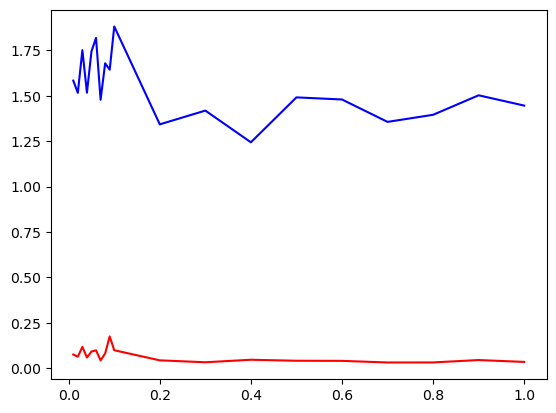

In [7]:
print(error_results_max)
print(error_results_avg)
#res=pd.DataFrame({"real":real_abs,"pred":pred_abs,"error":error})
#res.to_csv(resultsFileName, header=True, index=False)
plt.plot(data_increments,error_results_max,'b-')
plt.plot(data_increments,error_results_avg,'r-')
plt.show()

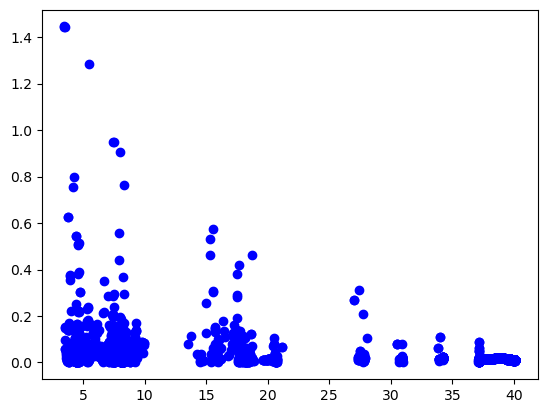

In [8]:

segment="access" if "access" in y_name else "metro"
model="M1" if len(x_names)==0 else "M2"

resultsFileName=os.getcwd()+"\\results\\"+rawDataFile+"_results["+segment+"_"+model+"_w"+str(w)+"].csv"
plotFileName=os.getcwd()+"\\results\\"+rawDataFile+"_results["+segment+"_"+model+"_w"+str(w)+"].png"
res=pd.DataFrame({"real":real_abs,"pred":pred_abs,"error":error})
res.to_csv(resultsFileName, header=True, index=False)

fig=plt.figure()
plt.plot(real_abs,error,'bo')
plt.show()
fig.savefig(plotFileName)